In [1]:
import tensorflow_probability as tfp

ImportError: cannot import name 'compiler' from 'tensorflow.python.autograph.pyct' (/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/__init__.py)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500]),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras import layers

Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [12]:
import tensorflow_datasets as tfds

In [13]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [27]:
ds_train_mnist_sm, ds_info_mnist_sm = tfds.load(
    'mnist',
    split=tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [15]:
(ds_train_fash, ds_test_fash), ds_info_fash = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [14]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #print(image.shape)
    print(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]).shape)
    print(tf.one_hot(label,10).shape)
    return tf.cast(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]), tf.float32) / 255., tf.one_hot(label,10)

def prep_data(ds, ds_info):
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()
#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

#ds_train_fash = prep_data(ds_train_fash, ds_info_fash)
#ds_test_fash = prep_data(ds_test_fash, ds_info_fash)

#ds_train_mnist_sm = prep_data(ds_train_mnist_sm, ds_info_mnist_sm)

(784,)
(10,)
(784,)
(10,)


In [21]:
from custom_nn import FCN, FCN_Mask #Linear

In [22]:
def get_input_dim(ds):
    return iter(ds).next()[0].shape[1]
def get_batch_size(ds):
    return iter(ds).next()[0].shape[0]

In [23]:
input_dim = get_input_dim(ds_train_mnist)
batch_size = get_batch_size(ds_train_mnist)

In [24]:
input_dim

784

In [25]:
def just_eval(model, ds_test, supermask=False):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    for x_batch_test, y_batch_test in ds_test:
        if supermask:
            eval_pred, _ = model(x_batch_test)
        else:
            eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

In [23]:
p = np.array([[0.5,0.1,0.7],[0.2,0.8,0.9]])

In [24]:
bernoulli = np.zeros(p.shape)
u = np.random.rand(*p.shape)

In [25]:
u

array([[0.45692503, 0.56408887, 0.13257814],
       [0.85375357, 0.40033397, 0.96590672]])

In [26]:
bernoulli[p > u] = 1
bernoulli[p < u] = 0

In [31]:
p

array([[0.5, 0.1, 0.7],
       [0.2, 0.8, 0.9]])

In [30]:
u

array([[0.45692503, 0.56408887, 0.13257814],
       [0.85375357, 0.40033397, 0.96590672]])

In [29]:
bernoulli

array([[1., 0., 1.],
       [0., 1., 0.]])

In [37]:
%timeit bernoulli[np.where(p>u)]

2.44 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%timeit bernoulli[p>u]

1.19 µs ± 10.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
def bernoulli_sampler(p):
    p = np.array(p)
    u = np.random.rand(*p.shape)
    bernoulli = np.zeros(p.shape)
    
    bernoulli[p > u] = 1
    bernoulli[p < u] = 0
    
    return bernoulli
    

# Fully Connected

## Baseline

In [26]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn = FCN(input_dim, layer_shapes=LAYER_SHAPES)

In [27]:
init = initializer()

initializer


In [32]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn, initial_weights = init.set_weights_man(fcn, mode="uniform", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False)

Glorot uniform with bound 0.0018
Glorot uniform with bound 0.0050
Glorot uniform with bound 0.0182


In [33]:
def just_train(model, ds_train, epochs=6):
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    gradient_history = []
    layerwise_output_all = []
    
    for epoch in range(epochs):
    
        #print(f"Start of epoch {epoch}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted, layerwise_output = model(x_batch_train)
                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)


            grads = tape.gradient(loss, model.trainable_weights)
            gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)
            acc_metric(y_batch_train,predicted)
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())

        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
    
    return loss_history, acc_history, layerwise_output_all, gradient_history #model, 

In [34]:
loss_history, acc_history, output_history, gradient_history = just_train(fcn, ds_train_mnist, epochs=200)

End of Epoch: 1: Accuracy = 0.113700 --- Mean Loss = 2.298454
End of Epoch: 2: Accuracy = 0.366650 --- Mean Loss = 1.708600
End of Epoch: 3: Accuracy = 0.529139 --- Mean Loss = 1.304879
End of Epoch: 4: Accuracy = 0.624100 --- Mean Loss = 1.058140
End of Epoch: 5: Accuracy = 0.686043 --- Mean Loss = 0.892960
End of Epoch: 6: Accuracy = 0.729656 --- Mean Loss = 0.774522
End of Epoch: 7: Accuracy = 0.762202 --- Mean Loss = 0.685213
End of Epoch: 8: Accuracy = 0.787385 --- Mean Loss = 0.615468
End of Epoch: 9: Accuracy = 0.807478 --- Mean Loss = 0.559302
End of Epoch: 10: Accuracy = 0.823933 --- Mean Loss = 0.513057
End of Epoch: 11: Accuracy = 0.837741 --- Mean Loss = 0.474096
End of Epoch: 12: Accuracy = 0.849475 --- Mean Loss = 0.440838
End of Epoch: 13: Accuracy = 0.859565 --- Mean Loss = 0.412108
End of Epoch: 14: Accuracy = 0.868352 --- Mean Loss = 0.386995
End of Epoch: 15: Accuracy = 0.876119 --- Mean Loss = 0.364805
End of Epoch: 16: Accuracy = 0.882985 --- Mean Loss = 0.345019
E

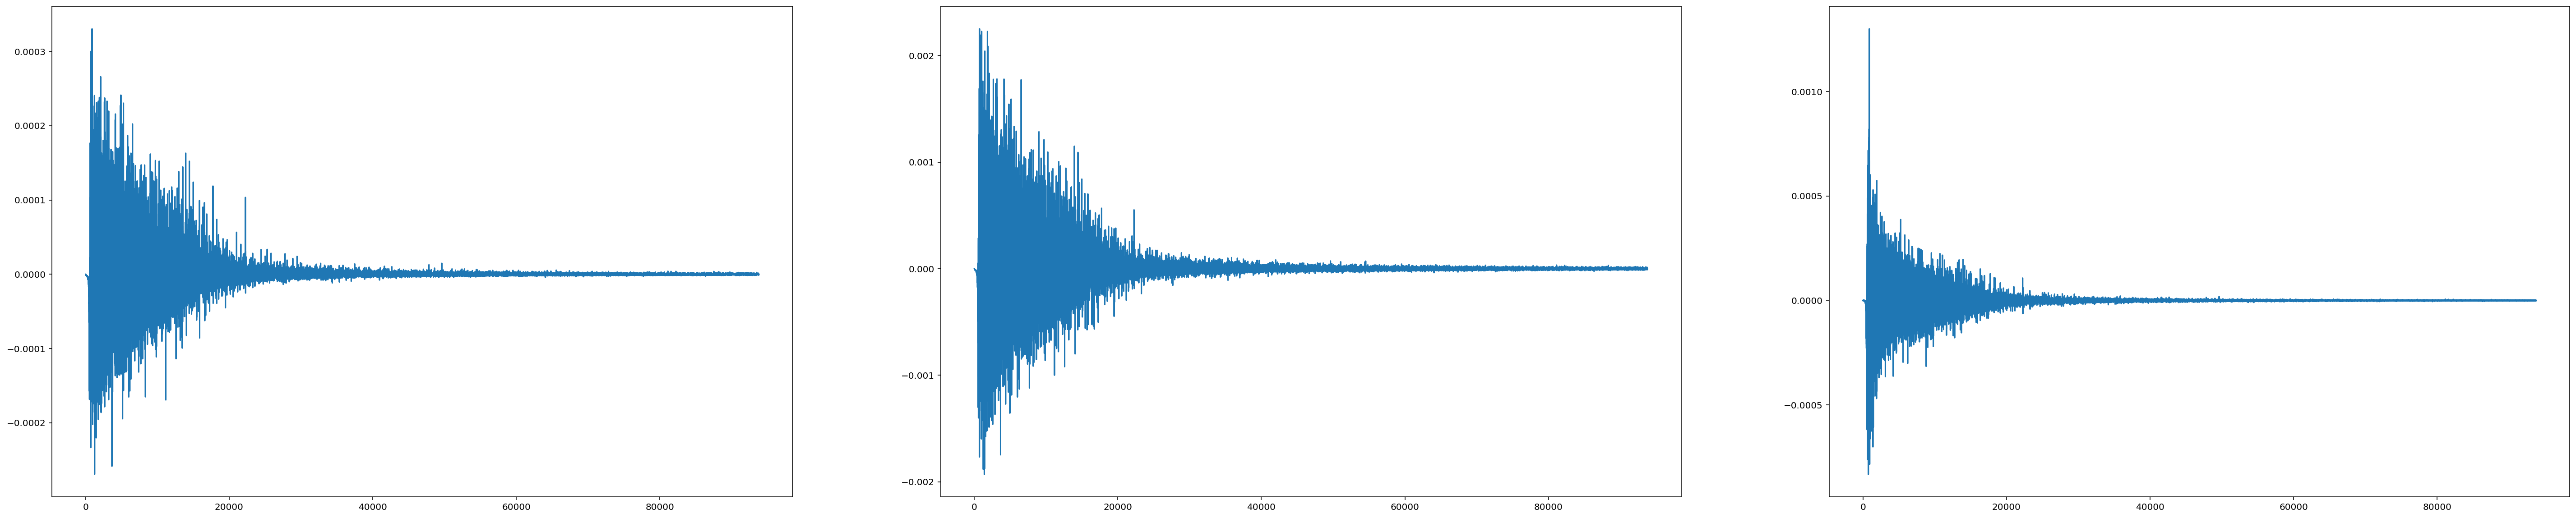

In [35]:
plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.plot(np.array(gradient_history)[:,0])
plt.subplot(1,3,2)
plt.plot(np.array(gradient_history)[:,1])
plt.subplot(1,3,3)
plt.plot(np.array(gradient_history)[:,2])

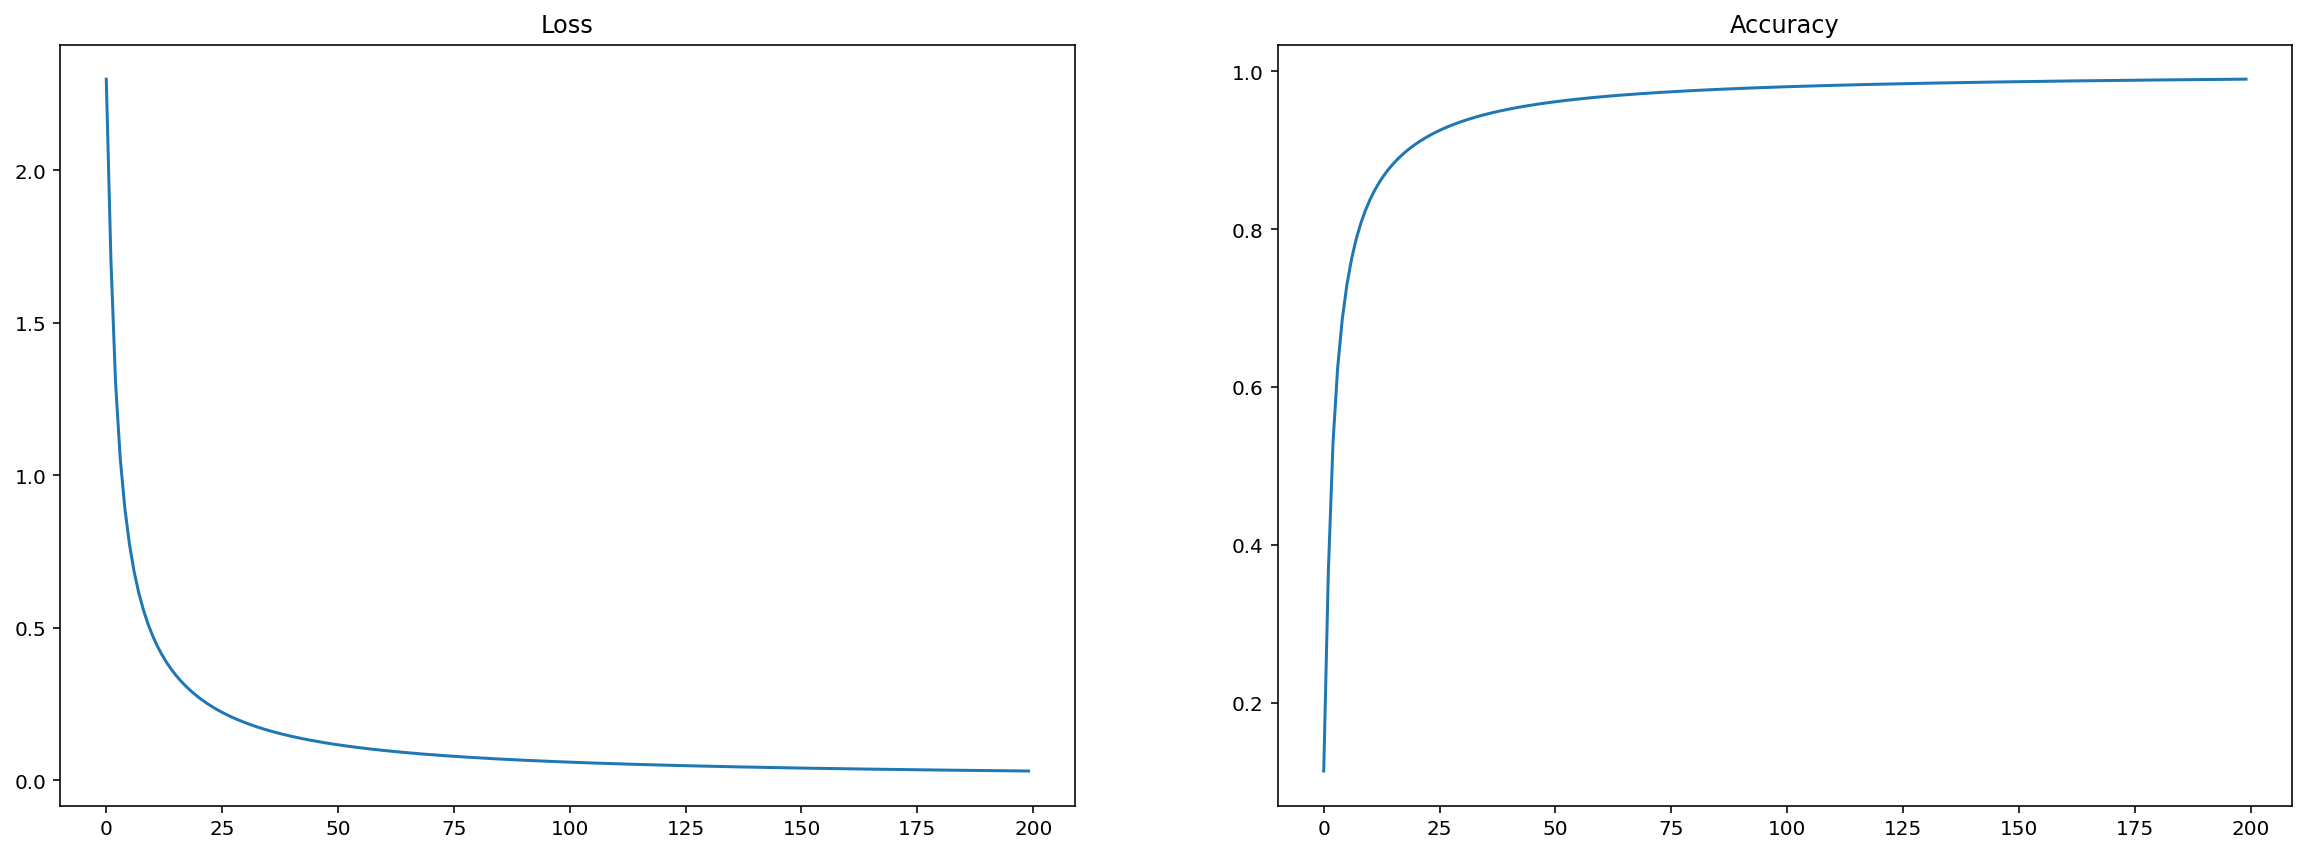

In [36]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(acc_history)

In [37]:
just_eval(fcn, ds_train_mnist, supermask=True)

Evaluation Loss: 0.0009596415911801159
Evaluation Accuracy: 0.9999499917030334


In [38]:
layerwise_output_mean = np.zeros((len(output_history),len(output_history[0])))
#layerwise_output_std = np.zeros((len(layerwise_output_all),len(layerwise_output_all[0])))


for i in range(len(output_history)):
    for j in range(len(output_history[0])):    
        layerwise_output_mean[i][j] = tf.math.reduce_mean(output_history[i][j]).numpy()
        #ayerwise_output_std[i][j] = tf.math.reduce_std(layerwise_output_all[i][j]).numpy()

In [39]:
_ = plt.hist(layerwise_output_std[:,0], bins=100)

NameError: name 'layerwise_output_std' is not defined

In [ ]:
#plt.fill_between(np.arange(len(layerwise_output_mean[:,0])), layerwise_output_mean[:,0]-layerwise_output_std[:,0], layerwise_output_mean[:,0]+layerwise_output_std[:,0], alpha=0.5)
plt.plot(layerwise_output_mean[:,0], label="Input")
plt.plot(layerwise_output_mean[:,1], label="First Layer (Dim 300)")
plt.plot(layerwise_output_mean[:,2], label="Second (hidden) Layer (Dim 100)")
plt.plot(layerwise_output_mean[:,3], label="Output Layer (Dim 10)")
plt.legend()

## Supermask

In [28]:
from custom_nn import Linear, FCN, FCN_Mask, FCN_Mask4, bernoulli_sampler

In [29]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
LAYER_SHAPES4 = np.array([[input_dim, 500], [500,300], [300,100], [100,10]])
SIG_MULTI = [.2,.2,.2]#[0.28,0.17,0.1] # [1.,1.,1.] # 
fcn_mask = FCN_Mask(input_dim, layer_shapes=LAYER_SHAPES, sigmoid_multiplier=SIG_MULTI, use_bernoulli_sampler=False)

In [30]:
init = initializer()

initializer


In [75]:
for i,layer in enumerate(fcn_mask.layers):
    layer.set_normal_weights(fcn.layers[i].get_weights()[0])

NameError: name 'fcn' is not defined

In [174]:
np.linalg.norm(fcn_mask.layers[0].bernoulli_mask.numpy(), ord=2)

13.717624

In [ ]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn_mask, initial_weights_mask = init.set_weights_man(fcn_mask, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)
fcn_mask, initial_masks = init.set_weights_man(fcn_mask, mode="normal", constant=0, mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)

In [65]:
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)

TypeError: set_weights_man() got an unexpected keyword argument 'use_bernoulli_sampler'

In [369]:
for i,layer in enumerate(fcn_mask.layers):
    layer.set_normal_weights(fcn.layers[i].get_weights()[0])

In [34]:
fcn_mask.trainable_weights

[<tf.Variable 'mask:0' shape=(784, 300) dtype=float32, numpy=
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(300,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
   

In [31]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="signed_constant", constant=-2, mu=MU, sigma=-1, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True) # uniform -3
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="uniform", constant=1, mu=MU, sigma=-5, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)_mas

Signed constant (std): 0.0018450184501845018
Signed constant (std): 0.005
Signed constant (std): 0.01818181818181818
Glorot uniform with bound 0.0067
Glorot uniform with bound 0.0200
Glorot uniform with bound 0.2000


In [32]:
fcn_mask.layers[0].get_mask(as_logit=True)

<tf.Variable 'mask:0' shape=(784, 300) dtype=float32, numpy=
array([[ 0.00571082, -0.00331133,  0.00079036, ..., -0.00388477,
        -0.00471082,  0.0049593 ],
       [-0.0063435 ,  0.00436277,  0.00499281, ...,  0.00582151,
         0.00289184, -0.00387494],
       [-0.00402895,  0.00518306,  0.0060022 , ...,  0.00462893,
        -0.00413599, -0.00146846],
       ...,
       [ 0.00123653, -0.00081258,  0.0036773 , ...,  0.0003095 ,
         0.00556743, -0.00167791],
       [ 0.00386733, -0.00413787, -0.00196719, ..., -0.00608862,
         0.00155998,  0.00343387],
       [ 0.006006  ,  0.00075321,  0.00218593, ..., -0.00552595,
        -0.00018377, -0.00546912]], dtype=float32)>

In [29]:
initial_weights[0]

[array([[ 0.00571082, -0.00331133,  0.00079036, ..., -0.00388477,
         -0.00471082,  0.0049593 ],
        [-0.0063435 ,  0.00436277,  0.00499281, ...,  0.00582151,
          0.00289184, -0.00387494],
        [-0.00402895,  0.00518306,  0.0060022 , ...,  0.00462893,
         -0.00413599, -0.00146846],
        ...,
        [ 0.00123653, -0.00081258,  0.0036773 , ...,  0.0003095 ,
          0.00556743, -0.00167791],
        [ 0.00386733, -0.00413787, -0.00196719, ..., -0.00608862,
          0.00155998,  0.00343387],
        [ 0.006006  ,  0.00075321,  0.00218593, ..., -0.00552595,
         -0.00018377, -0.00546912]])]

In [30]:
fcn_mask.layers[0].trainable_weights

[<tf.Variable 'mask:0' shape=(784, 300) dtype=float32, numpy=
 array([[ 0.00571082, -0.00331133,  0.00079036, ..., -0.00388477,
         -0.00471082,  0.0049593 ],
        [-0.0063435 ,  0.00436277,  0.00499281, ...,  0.00582151,
          0.00289184, -0.00387494],
        [-0.00402895,  0.00518306,  0.0060022 , ...,  0.00462893,
         -0.00413599, -0.00146846],
        ...,
        [ 0.00123653, -0.00081258,  0.0036773 , ...,  0.0003095 ,
          0.00556743, -0.00167791],
        [ 0.00386733, -0.00413787, -0.00196719, ..., -0.00608862,
          0.00155998,  0.00343387],
        [ 0.006006  ,  0.00075321,  0.00218593, ..., -0.00552595,
         -0.00018377, -0.00546912]], dtype=float32)>]

In [44]:
fcn_mask.layers[0].get_mask()

<tf.Tensor: shape=(784, 300), dtype=float32, numpy=
array([[0.50100756, 0.50054455, 0.50012916, ..., 0.49996394, 0.4994532 ,
        0.4998729 ],
       [0.4987717 , 0.49931923, 0.50144845, ..., 0.4994345 , 0.5007694 ,
        0.49950436],
       [0.5013771 , 0.50038373, 0.49908912, ..., 0.49859515, 0.5008487 ,
        0.4994524 ],
       ...,
       [0.499404  , 0.5013774 , 0.49973598, ..., 0.5007867 , 0.49837086,
        0.49862745],
       [0.5002758 , 0.501317  , 0.49920443, ..., 0.50049615, 0.49912083,
        0.5006259 ],
       [0.49969453, 0.49850577, 0.49980873, ..., 0.4987327 , 0.49980766,
        0.49957567]], dtype=float32)>

In [53]:
for layer in fcn_mask.layers:
    print(layer.type)

fefo
fefo
fefo


In [82]:
np.var(initial_weights[0][0])

1.4795092309456274e-05

In [113]:
fcn_mask.layers[0].set_weights(fcn_mask.layers[0].get_weights())

In [35]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def custom_loss(y, pred, model):
    x_ent = loss_fn(y,pred)
    no_ones_sqrt = sum([np.sum(layer.bernoulli_mask) for layer in model.layers]) ** 0.5
    
    return x_ent + 0.009 * no_ones_sqrt
                      

In [36]:
def get_zero_rows(model):
    rows_to_be_deleted = []
    rows_to_be_kept = []
    for i,layer in enumerate(model.layers):
        #import pdb; pdb.set_trace()
        a = layer.bernoulli_mask.numpy()
        row_delete = np.where(~a.any(axis=1))[0]
        row_keep = np.where(a.any(axis=1))[0]
        rows_to_be_deleted.append(row_delete)
        rows_to_be_kept.append(row_keep)

        col = np.where(~a.any(axis=0))[0]


        print(f"Layer {i}: {row_delete.shape[0]} Rows can be deleted and {col.shape[0]} Columns")

    return rows_to_be_deleted, rows_to_be_kept

def get_pruned_initial_weights(old_initial_weights, rows_to_be_kept, keep_input=True):
    new_initial_weights = []
    for i in range(len(rows_to_be_kept)):
        #print(i,"/",len(rows_to_be_kept))
        if i is 0:
            # do not delete any input neurons, yet
            if keep_input is True:
                #import pdb; pdb.set_trace()
                w = old_initial_weights[i][:, rows_to_be_kept[1]]
                #w = old_initial_weights[i][0][:, rows_to_be_kept[1]]
            else:
                w = old_initial_weights[i][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
                #w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]
        elif i is len(rows_to_be_kept)-1:
            w = old_initial_weights[i][rows_to_be_kept[i],:]
            #w = old_initial_weights[i][0][rows_to_be_kept[i],:]
            #b = old_initial_weights[i][1]
        else:
            w = old_initial_weights[i][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]


        #wb = [w,b]
        new_initial_weights.append(w)
        #new_initial_weights.append(wb)
        
    #import pdb; pdb.set_trace()

    return new_initial_weights

def get_new_shape(input_dim, rows_to_be_kept, keep_input=True):
    new_shape = []
    for i in range(len(rows_to_be_kept)):
        if i == 0:
            if keep_input is True:
                tmp = [input_dim, rows_to_be_kept[1].shape[0]]
            else:
                tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        elif i == len(rows_to_be_kept)-1:
            tmp = [rows_to_be_kept[i].shape[0], 10]
        else:
            tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        new_shape.append(tmp)
    return new_shape

In [37]:
from copy import copy

# Try to exclude rows/cols that are all zero from trainable weights

In [ ]:
var_list1 = [variables from first 5 layers]
var_list2 = [the rest of variables]
opt1 = tf.train.GradientDescentOptimizer(0.00001)
opt2 = tf.train.GradientDescentOptimizer(0.0001)
grads = tf.gradients(loss, var_list1 + var_list2)
grads1 = grads[:len(var_list1)]
grads2 = grads[len(var_list1):]
tran_op1 = opt1.apply_gradients(zip(grads1, var_list1))
train_op2 = opt2.apply_gradients(zip(grads2, var_list2))
train_op = tf.group(train_op1, train_op2)

In [ ]:
a = [tf.math.reduce_sum(x, axis=1) for x in trainable_weights]
b = [tf.where(x == 0) for x in a]
c = [tf.where(x != 0) for x in a]

nonzero_rows_trainable = [trainable_weights[i][c[i]] for i in range(len(c))]
zero_rows_nontrainable = [trainable_weights[i][b[i]] for i in range(len(b))]

# pseudo code
gradients(trainable_weights[c])


In [ ]:
intermediate_tensor = tf.math.reduce_sum(x, 1)
zero_vector = tf.zeros(shape=(1,1), dtype=tf.float32)

In [367]:
bool_mask = tf.not_equal(fcn_mask.layers[0].bernoulli_mask, 0.)

In [368]:
tf.boolean_mask(fcn_mask.layers[0].bernoulli_mask, bool_mask)

<tf.Tensor: shape=(10850,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [93]:
def train_supermask_model_prune(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr = 200
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)#tf.keras.optimizers.SGD(learning_rate=190, momentum=0.9) , momentum=0.9, nesterov=True
    
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    #input_dim = model.layers[0].shape[0]
    
    #new_initial_weights = [layer.get_normal_weights().numpy() for layer in model.layers]
    
    #new_initial_masks = [layer.mask.numpy() for layer in model.layers]
    
    #all_trainable_vars_original = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model.trainable_variables]).numpy()
    
    #smaller_model = copy(model)
    
    layerwise_output_all = []
    gradient_history = []
    
    epoch_half = epochs // 2
    
    for epoch in range(epochs):
        
        #if epoch == epoch_half:
        #    optimizer = tf.keras.optimizers.SGD(learning_rate = lr*0.7, momentum=0.9)
        
        #for i,layer in enumerate(model.layers):
        #    print(f"Layer {i} multiplier: {layer.multiplier:.4f}")
        
        #if epoch == 140:
            #optimizer = tf.keras.optimizers.SGD(learning_rate=70, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted, layerwise_output = model(x_batch_train)
                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)
                #loss = custom_loss(y_batch_train, predicted, model)
            #var_list1 = model.trainable_weights[:1]
            #var_list2 = model.trainable_weights[1:]
            
            trainable_weights_row_sum = [tf.math.reduce_sum(layer, axis=1) for layer in model.trainable_weights]
            
            
            
            grads = tape.gradient(loss, model.trainable_weights)

            gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #print(f"Gradient value mean: {tf.math.reduce_mean(grads[0]).numpy()}")
            
            optimizer.apply_gradients(zip(grads1, model.trainable_weights))
            
            #optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        
        global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
        global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])
        
        remaining_ones_ratio = (global_no_ones/global_size)*100
        print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
        remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, layerwise_output_all, gradient_history, remaining_ones_ratio_history

In [33]:
def train_supermask_model(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr1 = 1.
    lr2 = 1.25
    lr3 = 1.75
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr1, momentum=0.9)#tf.keras.optimizers.SGD(learning_rate=190, momentum=0.9) , momentum=0.9, nesterov=True tf.keras.optimizers.Adam(lr=lr1)#
    #optimizer_2 = tf.keras.optimizers.SGD(learning_rate=lr2, momentum=0.9) #tf.keras.optimizers.Adam(lr=lr2) #
    #optimizer_3 = tf.keras.optimizers.SGD(learning_rate=lr3, momentum=0.9) #tf.keras.optimizers.Adam(lr=lr3) #
    
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    #input_dim = model.layers[0].shape[0]
    
    #new_initial_weights = [layer.get_normal_weights().numpy() for layer in model.layers]
    
    #new_initial_masks = [layer.mask.numpy() for layer in model.layers]
    
    #all_trainable_vars_original = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model.trainable_variables]).numpy()
    
    #smaller_model = copy(model)
    
    layerwise_output_all = []
    gradient_history = []
    mask_history = []
    
    epoch_half = epochs // 2
    epoch_th = int(epochs * 0.67)
    
    for epoch in range(epochs):
        
        #if epoch == 15:
        #    optimizer = tf.keras.optimizers.SGD(learning_rate = lr1*0.8, momentum=0.9)
            #optimizer_2 = tf.keras.optimizers.SGD(learning_rate = lr2*0.8, momentum=0.9)
            #optimizer_3 = tf.keras.optimizers.SGD(learning_rate = lr3*0.8, momentum=0.9)
            
        
        #if epoch == epoch_half:
        #    optimizer = tf.keras.optimizers.SGD(learning_rate = lr1*0.67, momentum=0.9)
            #optimizer_2 = tf.keras.optimizers.SGD(learning_rate = lr2*0.67, momentum=0.9)
            #optimizer_3 = tf.keras.optimizers.SGD(learning_rate = lr3*0.67, momentum=0.9)
        
        
        #for i,layer in enumerate(model.layers):
        #    print(f"Layer {i} multiplier: {layer.multiplier:.4f}")
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted, layerwise_output = model(x_batch_train) #, epoch
                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)
                #loss = custom_loss(y_batch_train, predicted, model)
            #var_list1 = model.trainable_weights[:1]
            #var_list2 = model.trainable_weights[1:]
            
            grads = tape.gradient(loss, model.trainable_weights)
            #print(grads)
            #print(f"Gradients: {grads}")
            
            #grads1 = grads[:1]
            #grads2 = grads[1:2]
            #grads3 = grads[2:]
            #print(grads)
            gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #print(f"Gradient value mean: {tf.math.reduce_mean(grads[0]).numpy()}")
            
            #optimizer.apply_gradients(zip(grads[:1], model.trainable_weights[:1]))
            #optimizer_2.apply_gradients(zip(grads[1:2], model.trainable_weights[1:2]))
            #if epoch <= epoch_th:
            #    optimizer_3.apply_gradients(zip(grads[2:], model.trainable_weights[2:]))
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        mask_history.append([layer.bernoulli_mask for layer in model.layers])
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        
        global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
        global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])
        
        remaining_ones_ratio = (global_no_ones/global_size)*100
        print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
        remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, layerwise_output_all, gradient_history, remaining_ones_ratio_history, mask_history

In [29]:
ts = iter(ds_train_fash).next()[0]

In [30]:
ts_mnist = iter(ds_train_mnist).next()[0]

In [32]:
tf.reduce_mean(ts)

<tf.Tensor: shape=(), dtype=float32, numpy=0.28655612>

In [33]:
tf.math.reduce_std(ts)

<tf.Tensor: shape=(), dtype=float32, numpy=0.35785803>

In [34]:
tf.reduce_mean(ts_mnist)

<tf.Tensor: shape=(), dtype=float32, numpy=0.13345209>

In [35]:
tf.math.reduce_std(ts_mnist)

<tf.Tensor: shape=(), dtype=float32, numpy=0.31134552>

In [53]:
from custom_nn import Linear, FCN, FCN_Mask

In [145]:
fcn_mask.layers[0].get_weights()

[array([[ 0.00571082, -0.00331133,  0.00079036, ..., -0.00388477,
         -0.00471082,  0.0049593 ],
        [-0.0063435 ,  0.00436277,  0.00499281, ...,  0.00582151,
          0.00289184, -0.00387494],
        [-0.00402895,  0.00518306,  0.0060022 , ...,  0.00462893,
         -0.00413599, -0.00146846],
        ...,
        [ 0.00123653, -0.00081258,  0.0036773 , ...,  0.0003095 ,
          0.00556743, -0.00167791],
        [ 0.00386733, -0.00413787, -0.00196719, ..., -0.00608862,
          0.00155998,  0.00343387],
        [ 0.006006  ,  0.00075321,  0.00218593, ..., -0.00552595,
         -0.00018377, -0.00546912]], dtype=float32)]

In [148]:
tf.equal()

<function tensorflow.python.ops.math_ops.equal(x, y, name=None)>

In [62]:
fcn_mask.trainable_weights

[<tf.Variable 'mask:0' shape=(784, 300) dtype=float32, numpy=
 array([[ 0.00571082, -0.00331133,  0.00079036, ..., -0.00388477,
         -0.00471082,  0.0049593 ],
        [-0.0063435 ,  0.00436277,  0.00499281, ...,  0.00582151,
          0.00289184, -0.00387494],
        [-0.00402895,  0.00518306,  0.0060022 , ...,  0.00462893,
         -0.00413599, -0.00146846],
        ...,
        [ 0.00123653, -0.00081258,  0.0036773 , ...,  0.0003095 ,
          0.00556743, -0.00167791],
        [ 0.00386733, -0.00413787, -0.00196719, ..., -0.00608862,
          0.00155998,  0.00343387],
        [ 0.006006  ,  0.00075321,  0.00218593, ..., -0.00552595,
         -0.00018377, -0.00546912]], dtype=float32)>,
 <tf.Variable 'mask:0' shape=(300, 100) dtype=float32, numpy=
 array([[-1.95352510e-02, -1.41112246e-02, -1.81551352e-02, ...,
         -1.49389608e-02, -5.77369519e-03, -1.83397830e-02],
        [-4.33751242e-03,  1.99023485e-02, -3.42624751e-03, ...,
          1.10296125e-03,  9.71254834e-04,

In [34]:
fcn_mask, loss_history_mask, acc_history_mask, layerwise_output_all, gradient_history, ones_ratio_history, mask_history = train_supermask_model(fcn_mask, ds_train_mnist, epochs=100)

End of Epoch: 1: Accuracy = 0.662867 --- Mean Loss = 1.421005
43.81% of weights are 'remaining'
End of Epoch: 2: Accuracy = 0.770000 --- Mean Loss = 0.944071
39.67% of weights are 'remaining'
End of Epoch: 3: Accuracy = 0.813400 --- Mean Loss = 0.747576
37.57% of weights are 'remaining'
End of Epoch: 4: Accuracy = 0.838379 --- Mean Loss = 0.636992
36.20% of weights are 'remaining'
End of Epoch: 5: Accuracy = 0.854750 --- Mean Loss = 0.564951
35.19% of weights are 'remaining'
End of Epoch: 6: Accuracy = 0.866886 --- Mean Loss = 0.513404
34.25% of weights are 'remaining'
End of Epoch: 7: Accuracy = 0.876388 --- Mean Loss = 0.473856
33.24% of weights are 'remaining'
End of Epoch: 8: Accuracy = 0.884000 --- Mean Loss = 0.442375
32.27% of weights are 'remaining'
End of Epoch: 9: Accuracy = 0.890378 --- Mean Loss = 0.416315
31.29% of weights are 'remaining'
End of Epoch: 10: Accuracy = 0.895850 --- Mean Loss = 0.394301
30.33% of weights are 'remaining'
End of Epoch: 11: Accuracy = 0.900621 -

KeyboardInterrupt: 

# Why are there more ones when sigmoid_multiplier is smaller???

In [36]:
fcn_mask.layers[0].trainable_weights

[<tf.Variable 'mask:0' shape=(784, 300) dtype=float32, numpy=
 array([[-0.0400605 , -0.04908228, -0.04498078, ..., -0.04965571,
         -0.05048174, -0.040812  ],
        [-0.05211437, -0.04140848, -0.04077849, ..., -0.0399498 ,
         -0.04287936, -0.04964587],
        [-0.04979988, -0.04058824, -0.03976912, ..., -0.04114236,
         -0.04990692, -0.04723949],
        ...,
        [-0.04453462, -0.04658364, -0.04209393, ..., -0.0454616 ,
         -0.04020388, -0.04744892],
        [-0.0419039 , -0.0499088 , -0.04773819, ..., -0.0518595 ,
         -0.04421118, -0.04233734],
        [-0.03976532, -0.04501792, -0.04358525, ..., -0.05129685,
         -0.04595485, -0.05124003]], dtype=float32)>]

In [34]:
fcn_mask.layers[0].non_trainable_weights

[<tf.Variable 'b:0' shape=(300,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0

In [35]:
fcn_mask.layers[0].w

<tf.Variable 'w:0' shape=(784, 300) dtype=float32, numpy=
array([[ 0.00666667, -0.00666667,  0.00666667, ..., -0.00666667,
         0.00666667, -0.00666667],
       [-0.00666667, -0.00666667, -0.00666667, ...,  0.00666667,
         0.00666667,  0.00666667],
       [-0.00666667,  0.00666667,  0.00666667, ...,  0.00666667,
         0.00666667, -0.00666667],
       ...,
       [-0.00666667,  0.00666667,  0.00666667, ...,  0.00666667,
         0.00666667, -0.00666667],
       [ 0.00666667,  0.00666667,  0.00666667, ..., -0.00666667,
        -0.00666667,  0.00666667],
       [ 0.00666667, -0.00666667,  0.00666667, ...,  0.00666667,
         0.00666667, -0.00666667]], dtype=float32)>

In [33]:
fcn_mask.layers[0].get_weights()

[array([[ 0.00571082, -0.00331133,  0.00079036, ..., -0.00388477,
         -0.00471082,  0.0049593 ],
        [-0.0063435 ,  0.00436277,  0.00499281, ...,  0.00582151,
          0.00289184, -0.00387494],
        [-0.00402895,  0.00518306,  0.0060022 , ...,  0.00462893,
         -0.00413599, -0.00146846],
        ...,
        [ 0.00123653, -0.00081258,  0.0036773 , ...,  0.0003095 ,
          0.00556743, -0.00167791],
        [ 0.00386733, -0.00413787, -0.00196719, ..., -0.00608862,
          0.00155998,  0.00343387],
        [ 0.006006  ,  0.00075321,  0.00218593, ..., -0.00552595,
         -0.00018377, -0.00546912]], dtype=float32)]

In [69]:
np.ones((784,300)).shape

(784, 300)

In [71]:
fcn_mask.layers[0].set_weights([np.ones((784,300))])

In [74]:
fcn_mask.layers[0].non_trainable_weights

[<tf.Variable 'Variable:0' shape=(784, 300) dtype=float32, numpy=
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>]

In [72]:
fcn_mask.layers[0].get_mask()

<tf.Tensor: shape=(784, 300), dtype=float32, numpy=
array([[0.7310586, 0.7310586, 0.7310586, ..., 0.7310586, 0.7310586,
        0.7310586],
       [0.7310586, 0.7310586, 0.7310586, ..., 0.7310586, 0.7310586,
        0.7310586],
       [0.7310586, 0.7310586, 0.7310586, ..., 0.7310586, 0.7310586,
        0.7310586],
       ...,
       [0.7310586, 0.7310586, 0.7310586, ..., 0.7310586, 0.7310586,
        0.7310586],
       [0.7310586, 0.7310586, 0.7310586, ..., 0.7310586, 0.7310586,
        0.7310586],
       [0.7310586, 0.7310586, 0.7310586, ..., 0.7310586, 0.7310586,
        0.7310586]], dtype=float32)>

In [47]:
fcn_mask.trainable_weights

[]

In [93]:
fcn_mask.layers[0].bernoulli_mask

<tf.Tensor: shape=(784, 300), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

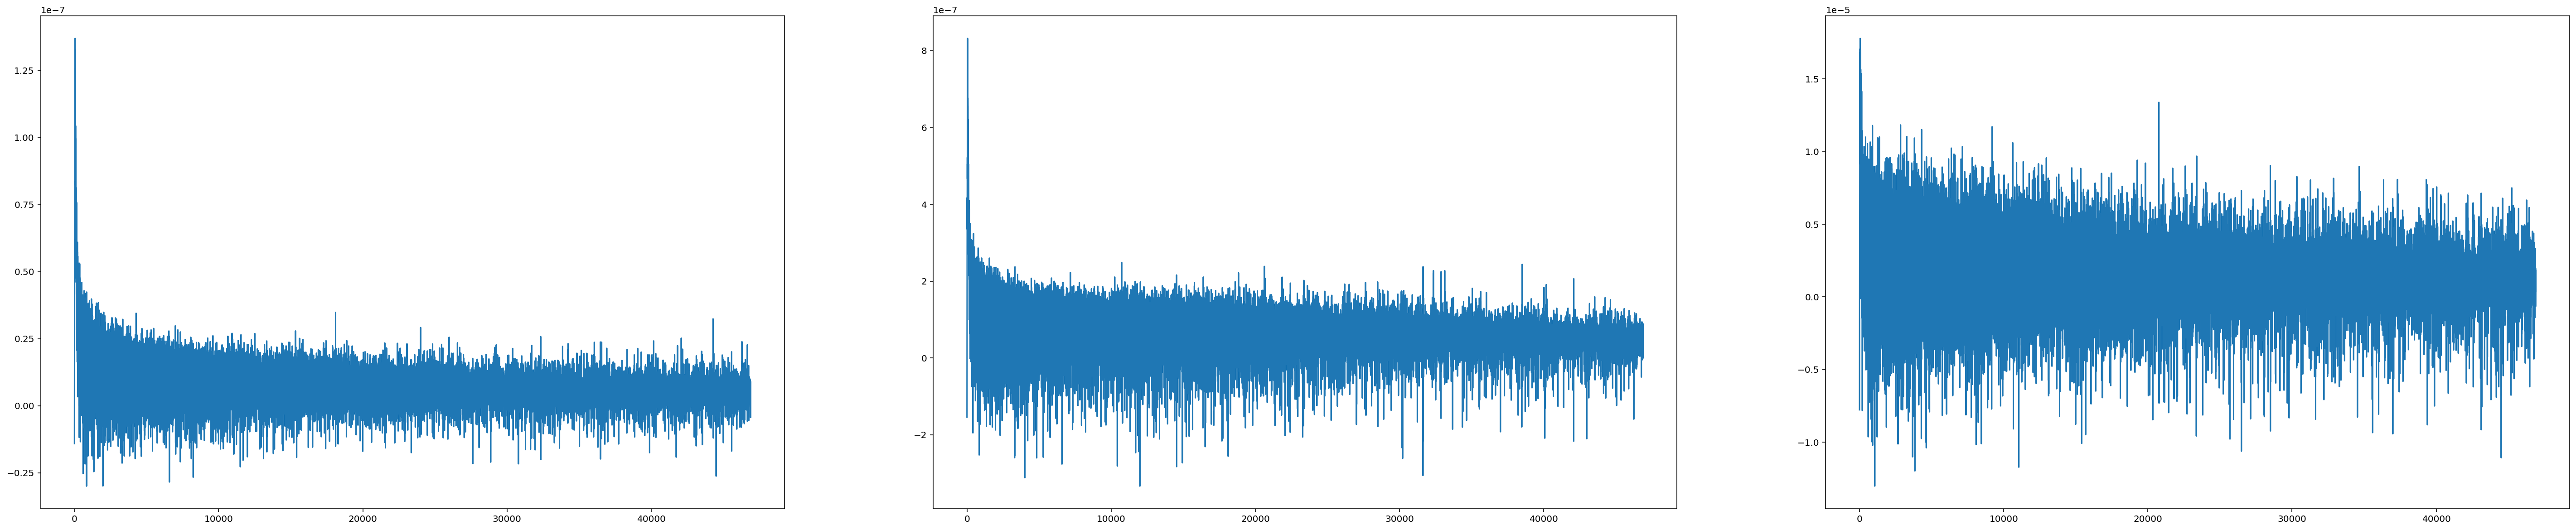

In [86]:
plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.plot(np.array(gradient_history)[:,0])
plt.subplot(1,3,2)
plt.plot(np.array(gradient_history)[:,1])
plt.subplot(1,3,3)
plt.plot(np.array(gradient_history)[:,2])

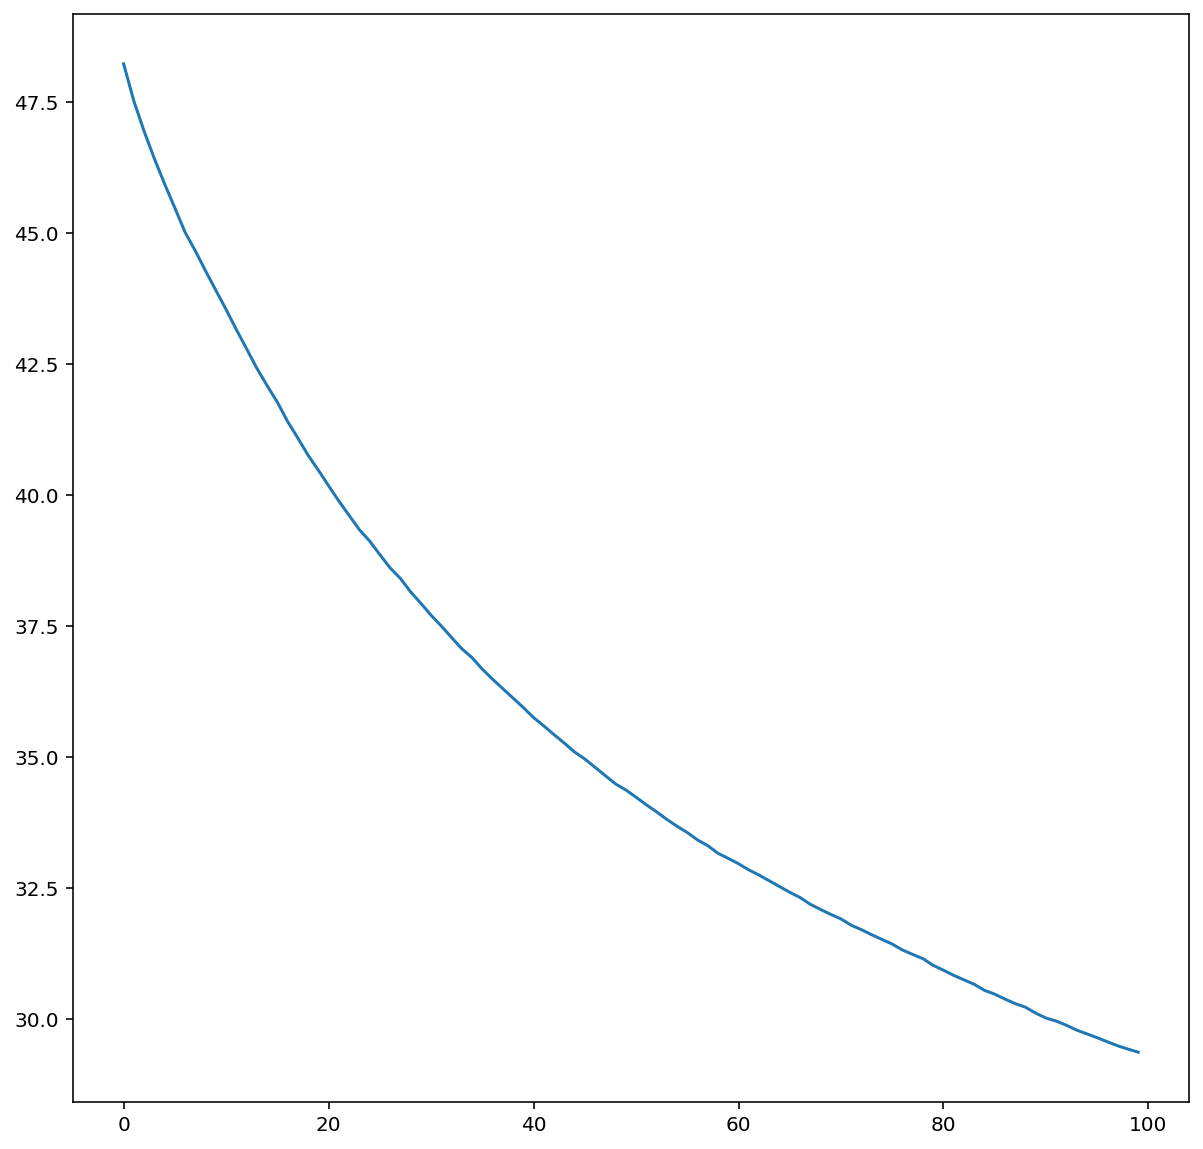

In [87]:
plt.plot(ones_ratio_history)

In [62]:
layerwise_output_mean = np.zeros((len(layerwise_output_all),len(layerwise_output_all[0])))
layerwise_output_std = np.zeros((len(layerwise_output_all),len(layerwise_output_all[0])))


for i in range(len(layerwise_output_all)):
    for j in range(len(layerwise_output_all[0])):    
        layerwise_output_mean[i][j] = tf.math.reduce_mean(layerwise_output_all[i][j]).numpy()
        layerwise_output_std[i][j] = tf.math.reduce_std(layerwise_output_all[i][j]).numpy()

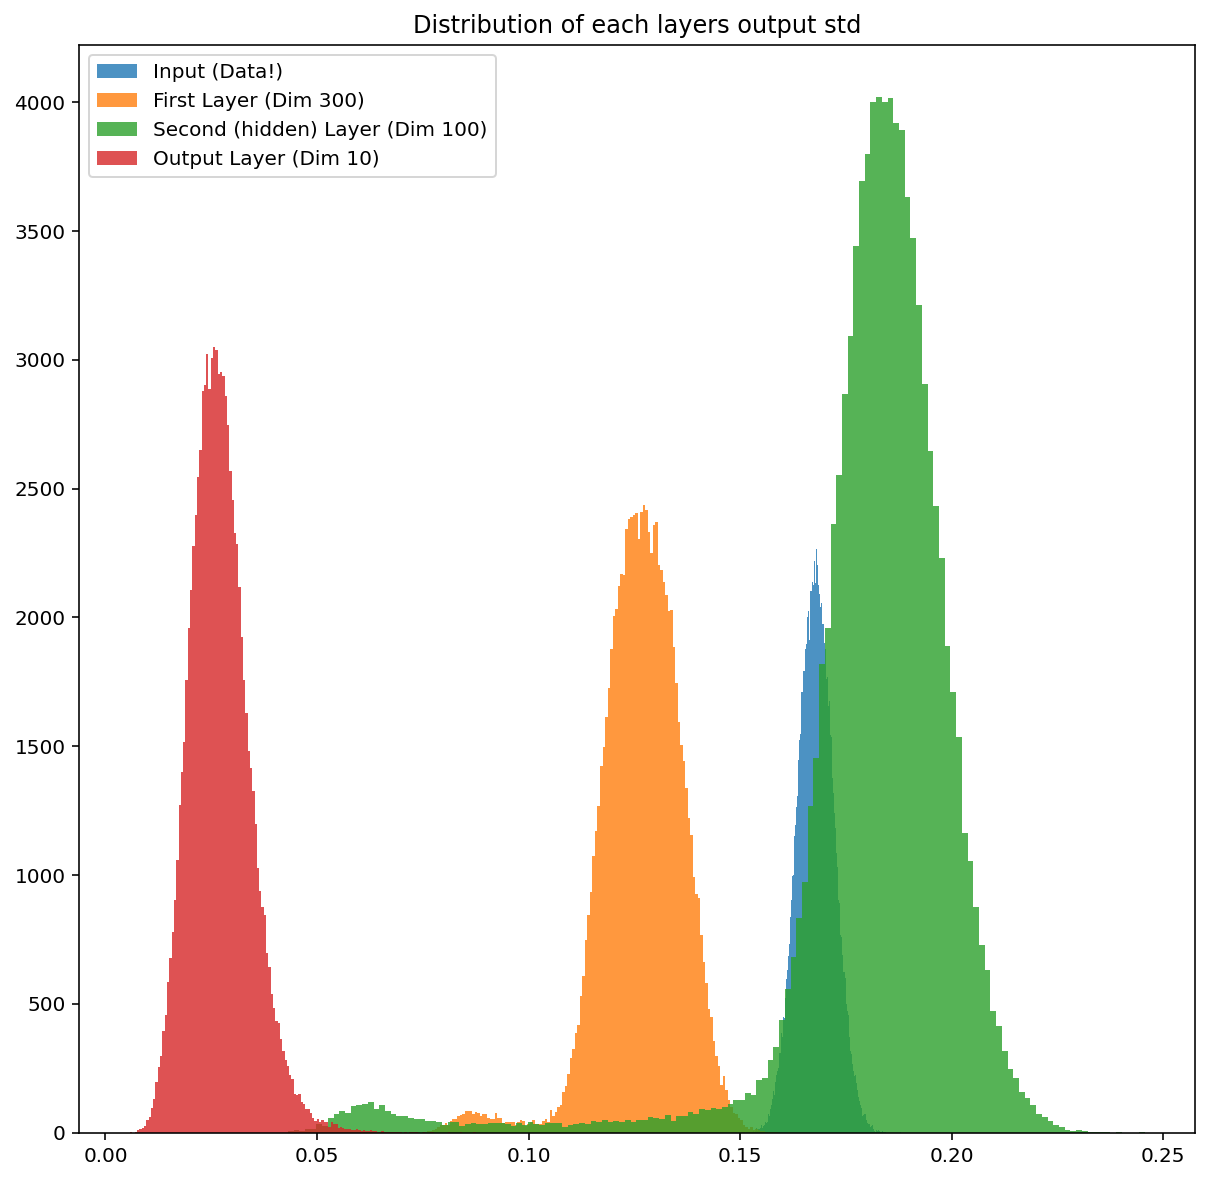

In [63]:
plt.title("Distribution of each layers output std")
_ = plt.hist(layerwise_output_std[:,0], bins=150, alpha=0.8, label="Input (Data!)")
_ = plt.hist(layerwise_output_std[:,1], bins=150, alpha=0.8,  label="First Layer (Dim 300)")
_ = plt.hist(layerwise_output_std[:,2], bins=150, alpha=0.8,  label="Second (hidden) Layer (Dim 100)")
_ = plt.hist(layerwise_output_std[:,3], bins=150, alpha=0.8,  label="Output Layer (Dim 10)")
plt.legend()

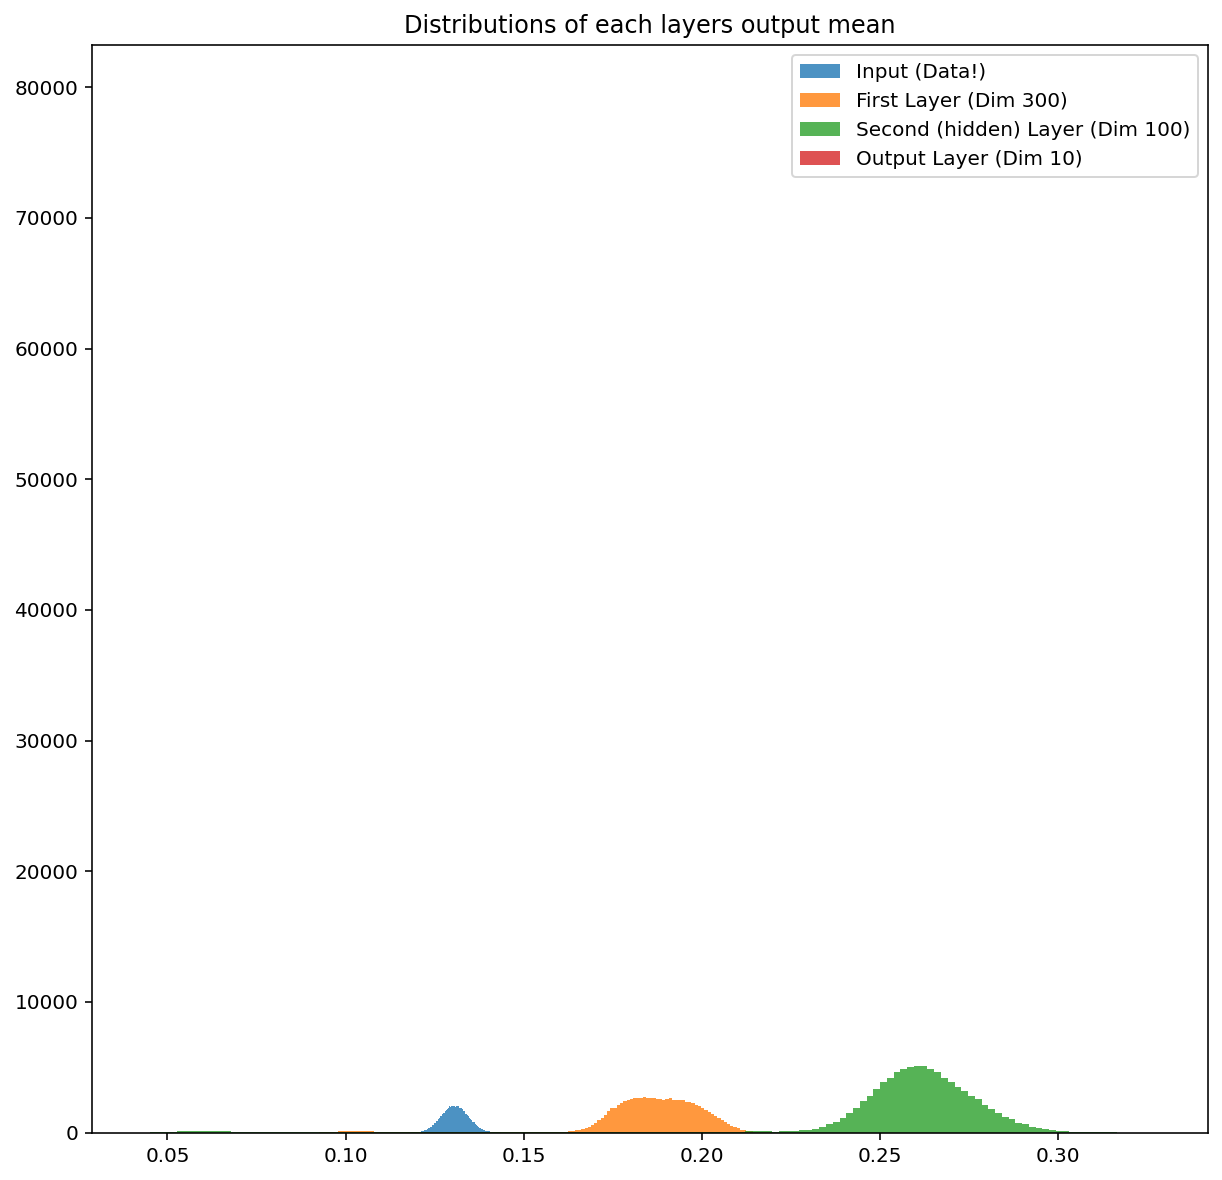

In [64]:
plt.title("Distributions of each layers output mean")
_ = plt.hist(layerwise_output_mean[:,0], bins=150, alpha=0.8, label="Input (Data!)")
_ = plt.hist(layerwise_output_mean[:,1], bins=150, alpha=0.8,  label="First Layer (Dim 300)")
_ = plt.hist(layerwise_output_mean[:,2], bins=150, alpha=0.8,  label="Second (hidden) Layer (Dim 100)")
_ = plt.hist(layerwise_output_mean[:,3], bins=150, alpha=0.8,  label="Output Layer (Dim 10)")
plt.legend()

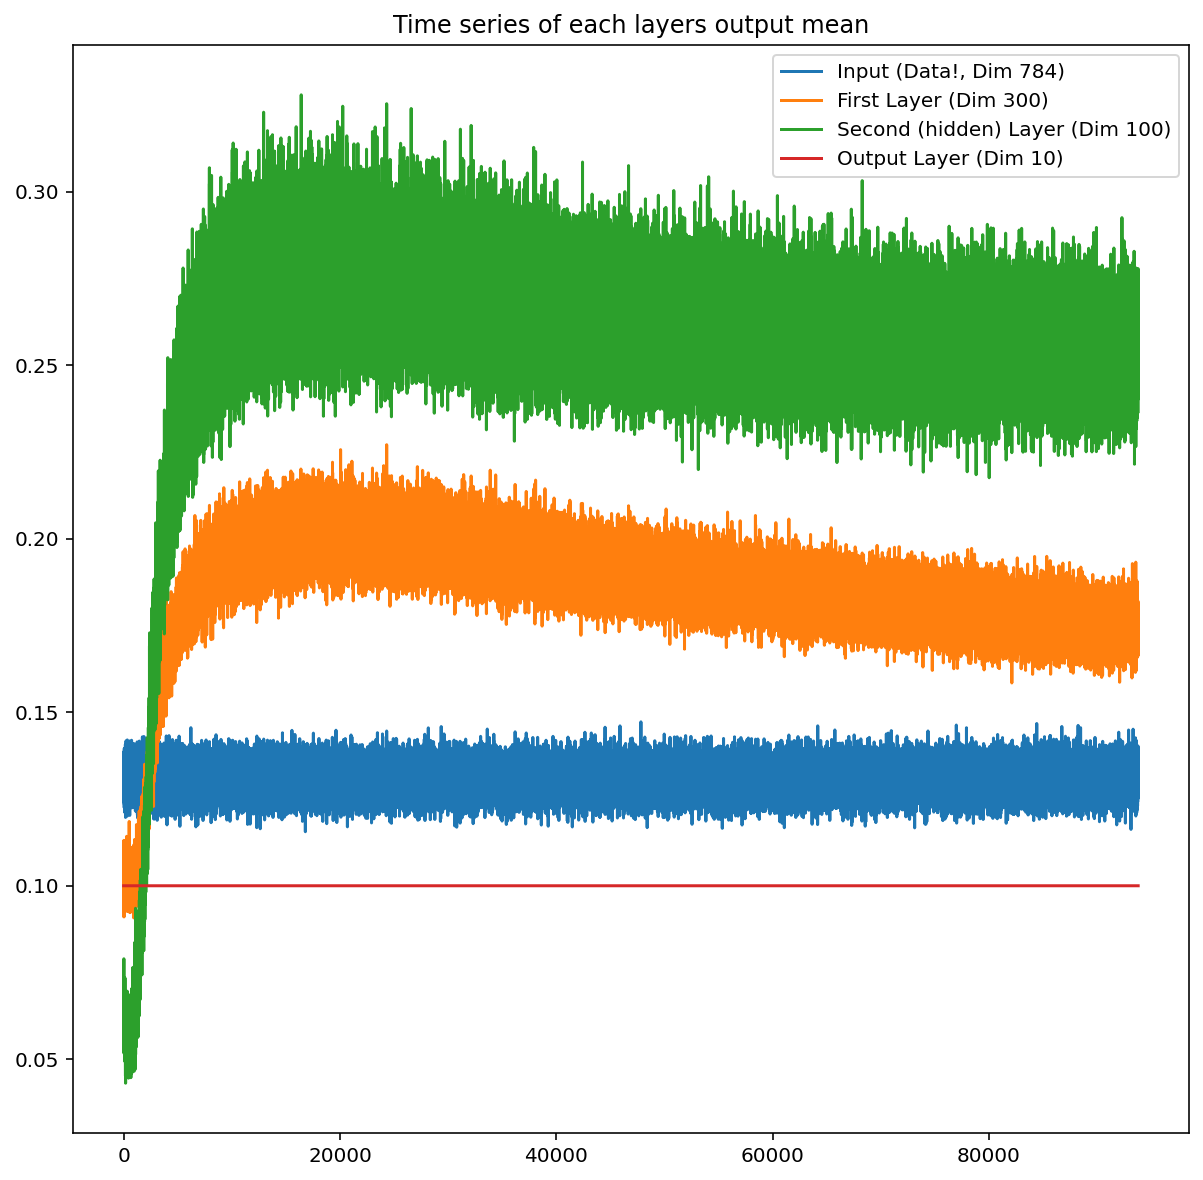

In [65]:
#plt.fill_between(np.arange(len(layerwise_output_mean[:,0])), layerwise_output_mean[:,0]-layerwise_output_std[:,0], layerwise_output_mean[:,0]+layerwise_output_std[:,0], alpha=0.5)
plt.title("Time series of each layers output mean")
plt.plot(layerwise_output_mean[:,0], label="Input (Data!, Dim 784)")
plt.plot(layerwise_output_mean[:,1], label="First Layer (Dim 300)")
plt.plot(layerwise_output_mean[:,2], label="Second (hidden) Layer (Dim 100)")
plt.plot(layerwise_output_mean[:,3], label="Output Layer (Dim 10)")
plt.legend()

In [66]:
import gc
gc.collect()

2977

In [67]:
masks_trained_weights = [layer.bernoulli_mask for layer in fcn_mask.layers]

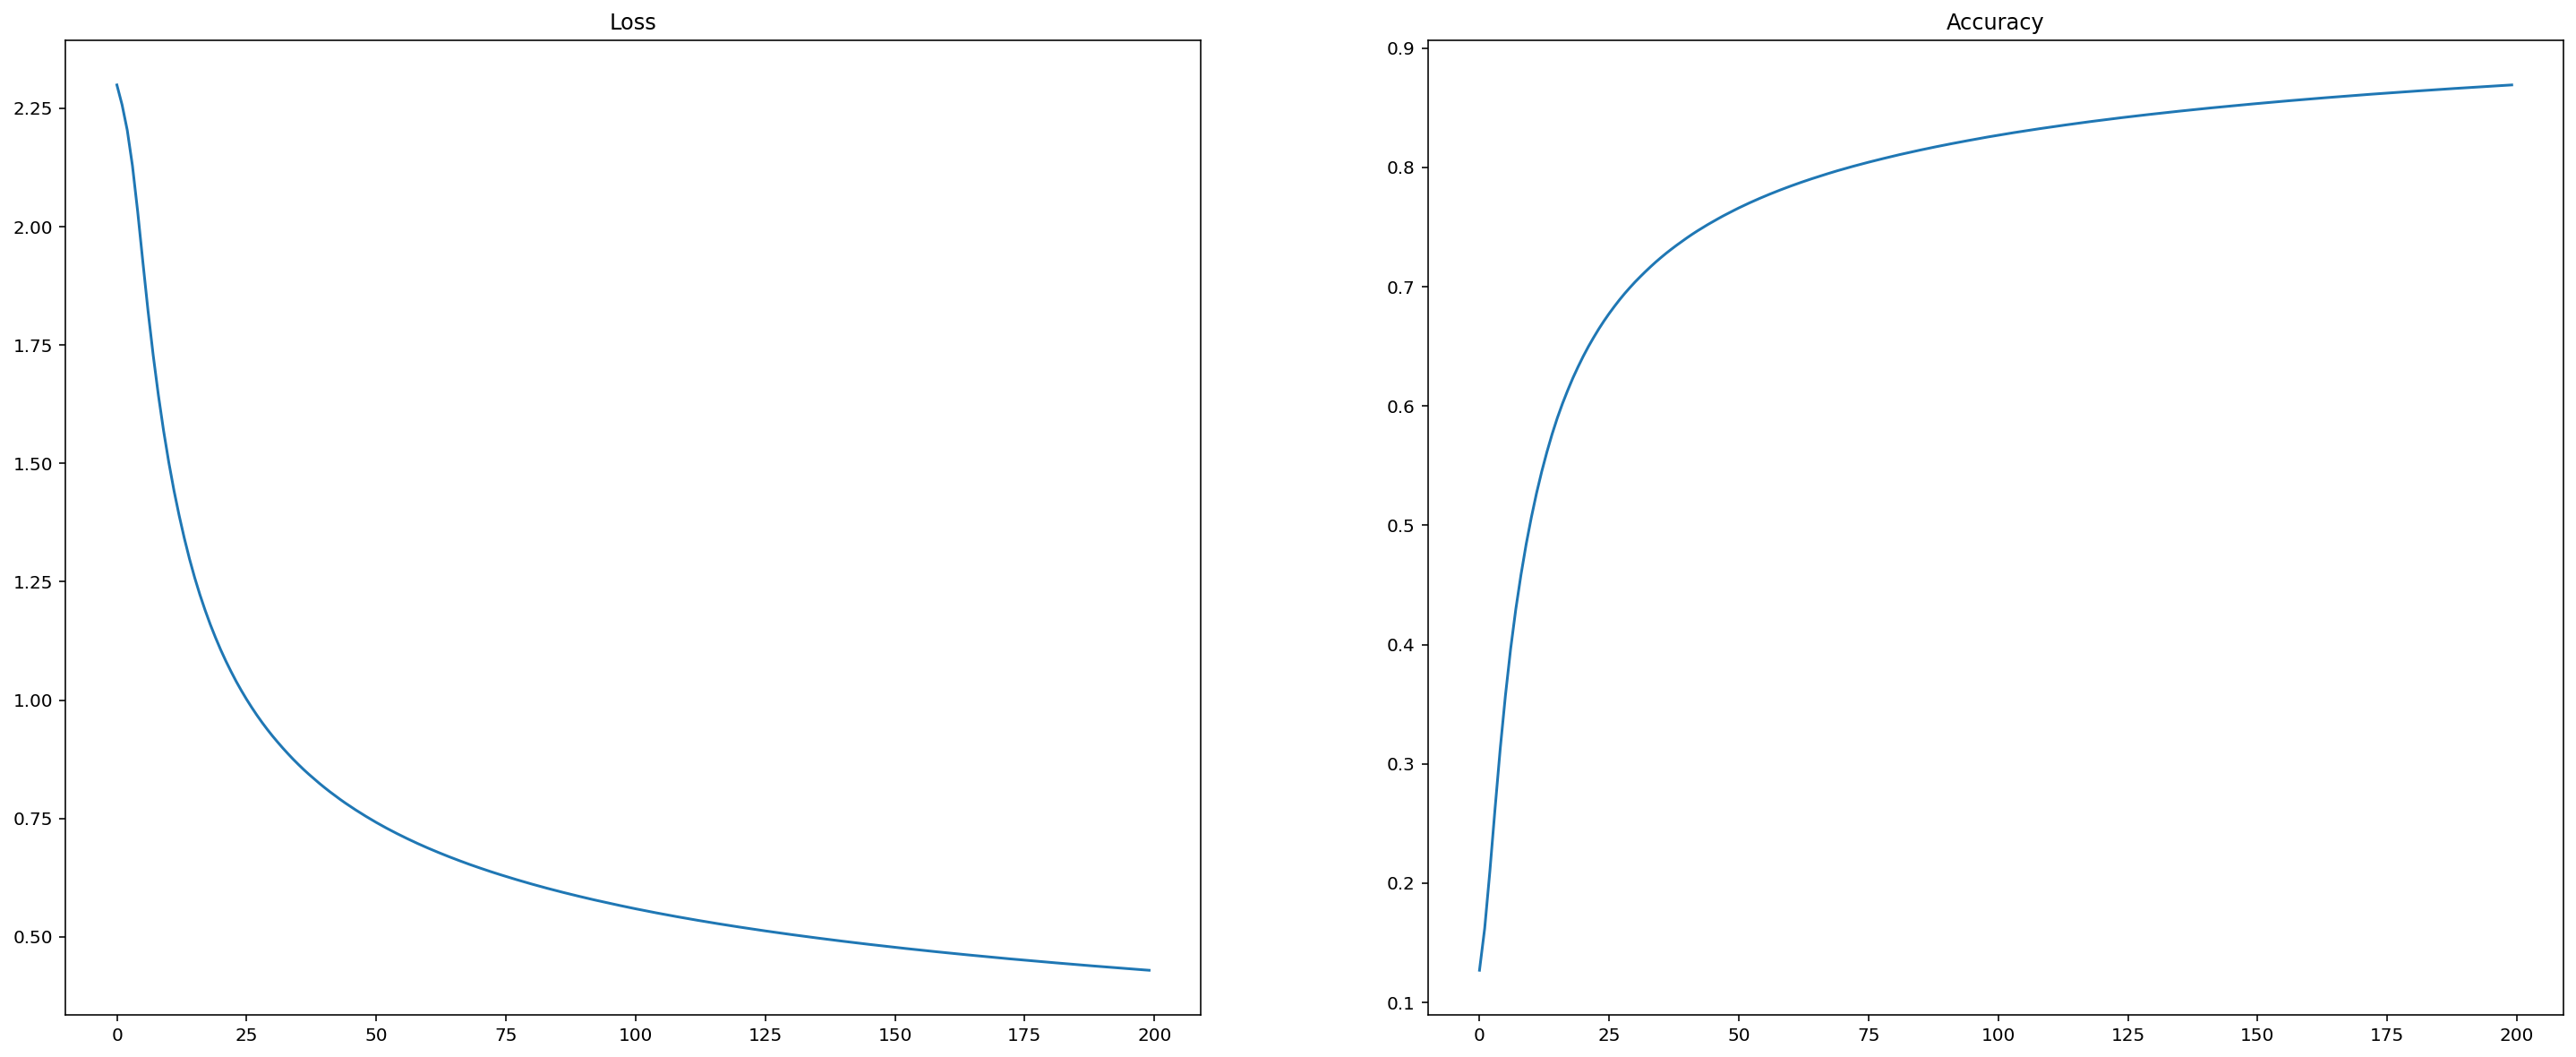

In [68]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(loss_history_mask)
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(acc_history_mask)

In [69]:
global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])

In [70]:
global_no_ones / global_size

0.4803230653643877

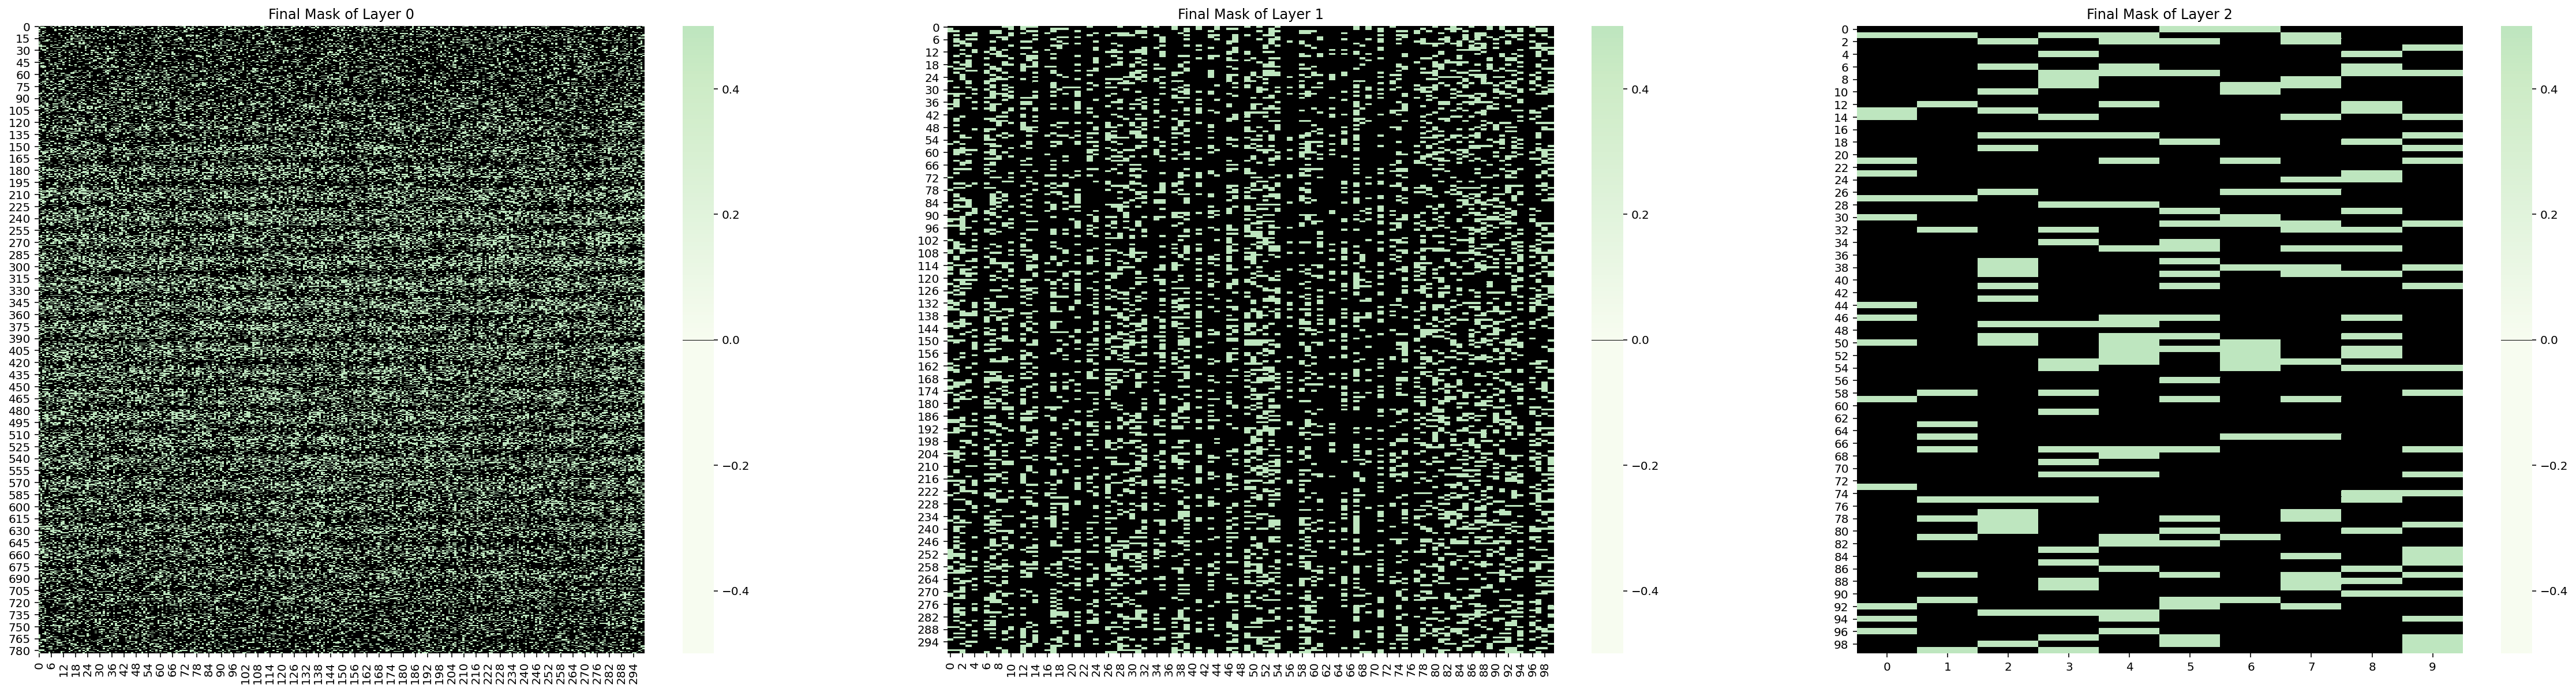

In [89]:
plt.figure(figsize=(40,10))
for layer in range(len(fcn_mask.trainable_weights)):
    plt.subplot(1,len(fcn_mask.trainable_weights),layer+1)
    mask = fcn_mask.layers[layer].bernoulli_mask.numpy()
    _ = sns.heatmap(mask, cbar=True, cmap=cmap, vmin=-0.5, vmax=0.5)
    plt.title(f"Final Mask of Layer {layer}")
#plt.savefig("./img/final_mask_delta_high_same_sign.png", dpi=1000, bbox_inches="tight")

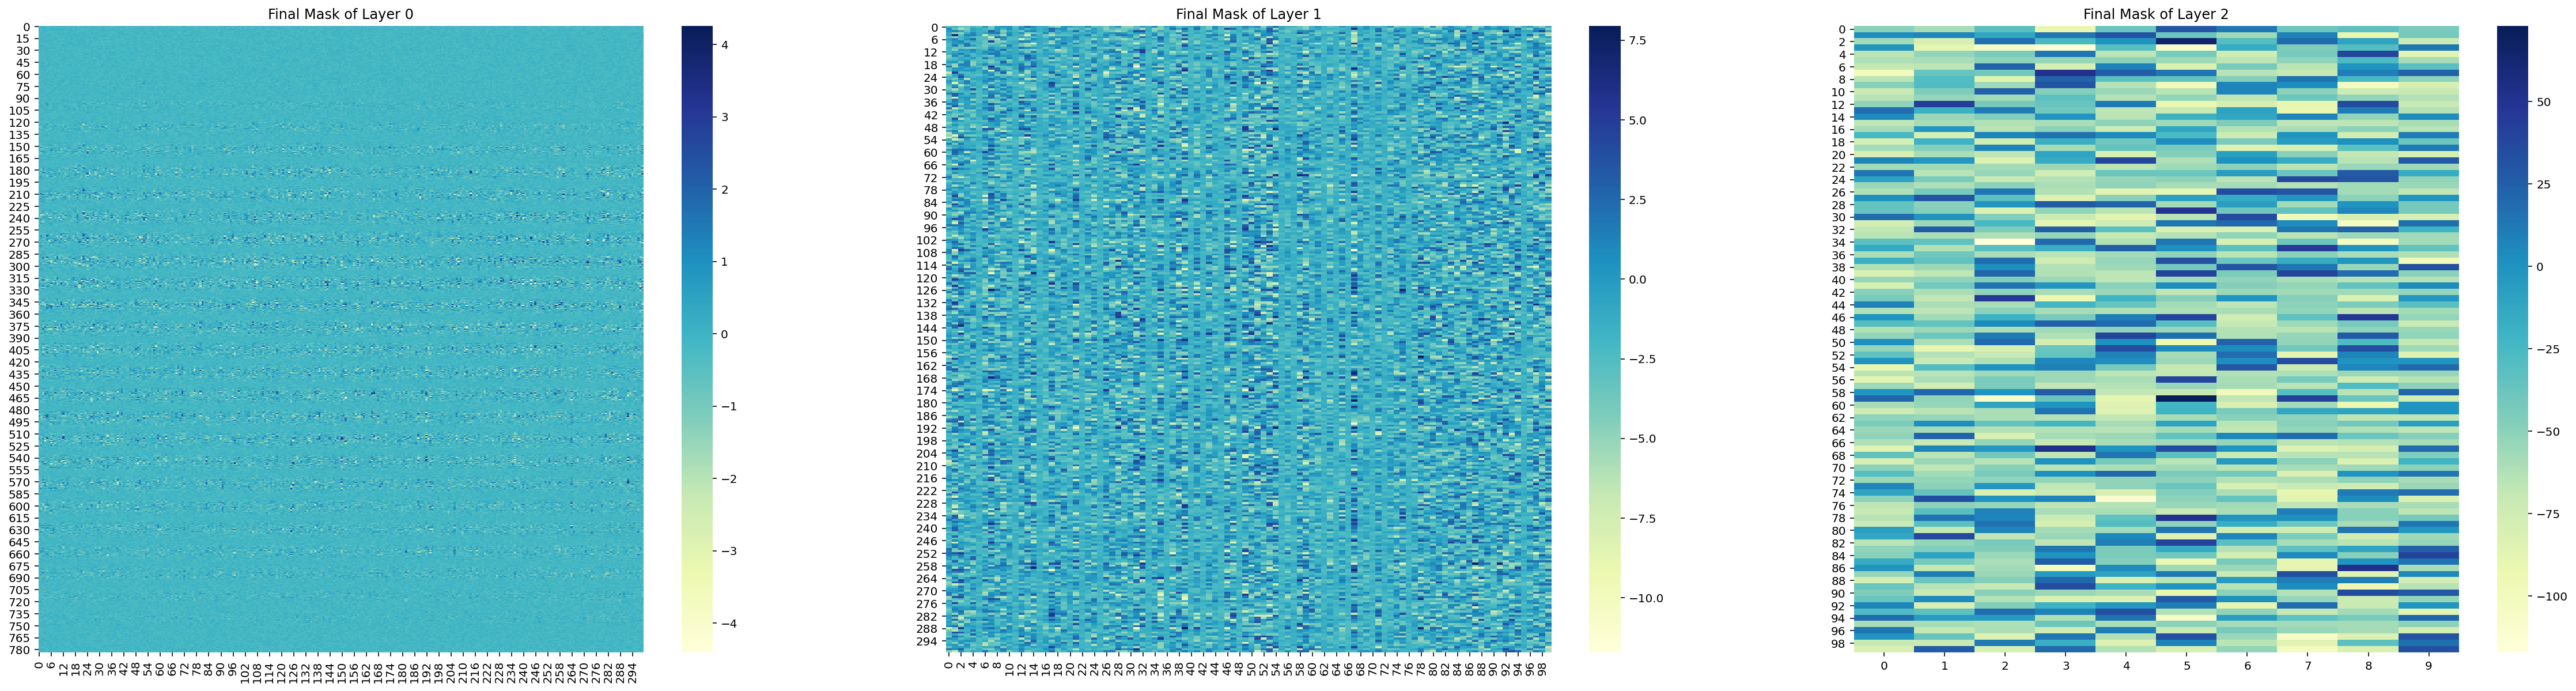

In [88]:
plt.figure(figsize=(40,10))
for layer in range(len(fcn_mask.trainable_weights)):
    plt.subplot(1,len(fcn_mask.trainable_weights),layer+1)
    mask = fcn_mask.layers[layer].mask.numpy() * fcn_mask.layers[layer].multiplier
    _ = sns.heatmap(mask, cbar=True, cmap="YlGnBu")
    plt.title(f"Final Mask of Layer {layer}")
#sns.heatmap(fcn_mask.layers[0].mask.numpy())

In [68]:
for layer in fcn_mask.layers:
    print(layer.multiplier)

tf.Tensor(49.536648, shape=(), dtype=float32)
tf.Tensor(333.33334, shape=(), dtype=float32)
tf.Tensor(71.42857, shape=(), dtype=float32)


In [138]:
just_eval(fcn_mask, ds_test_mnist, supermask=True)

Evaluation Loss: 0.0879349559545517
Evaluation Accuracy: 0.979200005531311


In [104]:
np.zeros(3,)[2]

0.0

In [114]:
a = {0:0, 1:1}

In [117]:
1 in a.keys()

True

In [196]:
total_params = np.multiply(*mask_history[0][0].shape)
no_changes = []#np.zeros(len(mask_history),)
for i in range(1,len(mask_history)):
    no_changes_tmp = []#np.zeros(3,)
    for l in range(NO_LAYERS):
        mask_diff = mask_history[i-1][l] - mask_history[i][l]
        
        rel_no_ones = (np.sum(np.absolute(mask_diff)) / total_params) * 100
        
        no_changes_tmp.append(rel_no_ones)
        
    no_changes.append(no_changes_tmp)
    #print(f"Epoch {i}: {dict_counts[1]} ({(dict_counts[1]/total_params)*100:.2f}%) 1's meaning that these masks changed (total params: {total_params})")
    #print(f"Epoch {i}: {dict_counts[0]} ({(dict_counts[0]/total_params)*100:.2f}%) 1's meaning that these masks changed (total params: {total_params})")
no_changes = np.array(no_changes)

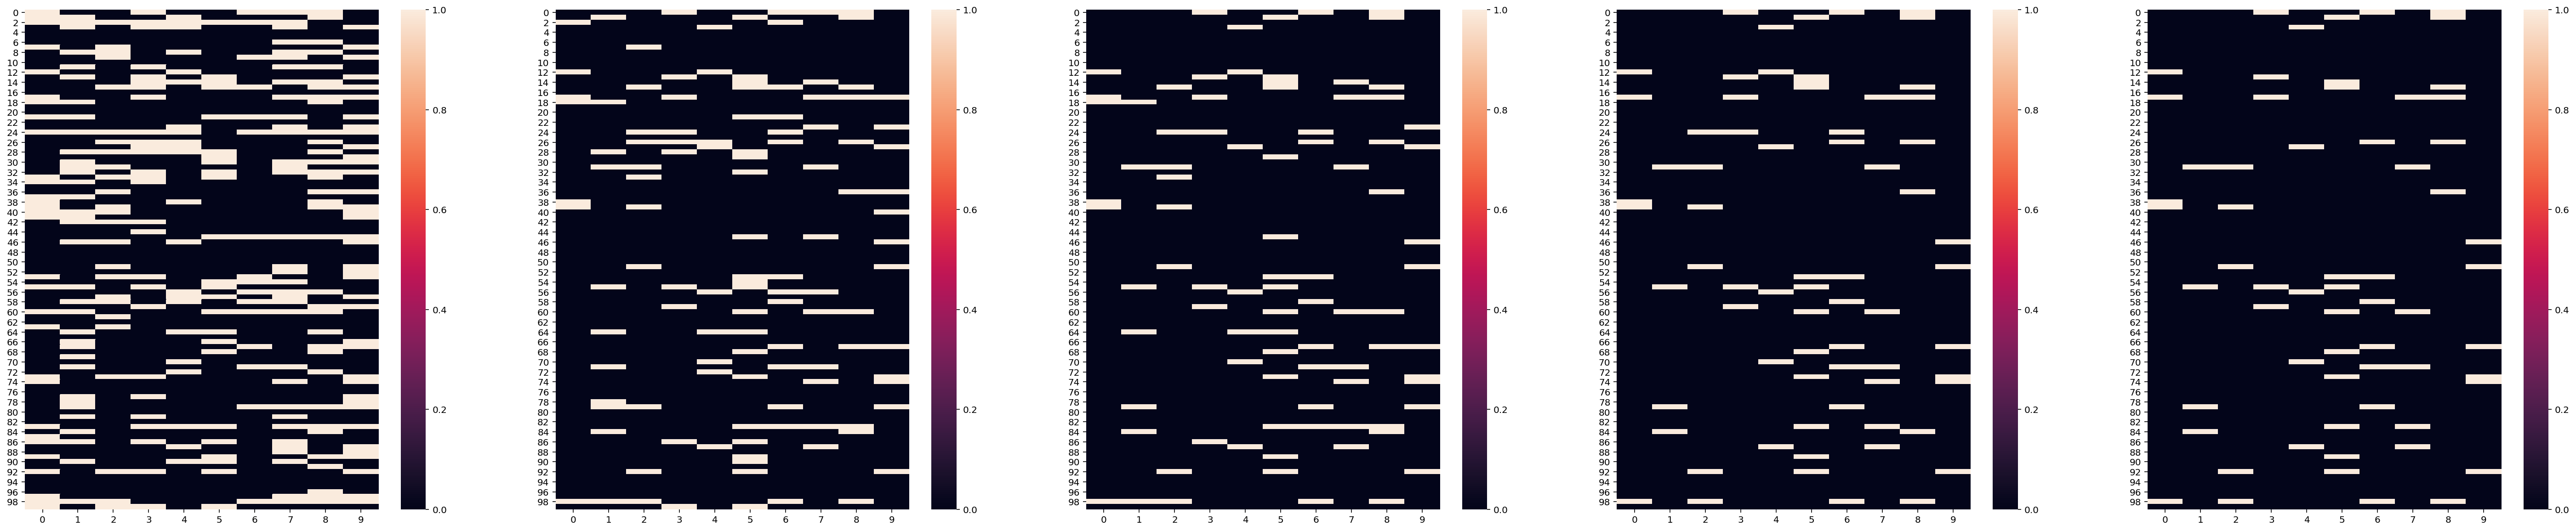

In [204]:
plt.figure(figsize=(50,10))
plt.subplot(1,5,1)
sns.heatmap(mask_history[0][2])
plt.subplot(1,5,2)
sns.heatmap(mask_history[20][2])
plt.subplot(1,5,3)
sns.heatmap(mask_history[40][2])
plt.subplot(1,5,4)
sns.heatmap(mask_history[60][2])
plt.subplot(1,5,5)
sns.heatmap(mask_history[80][2])

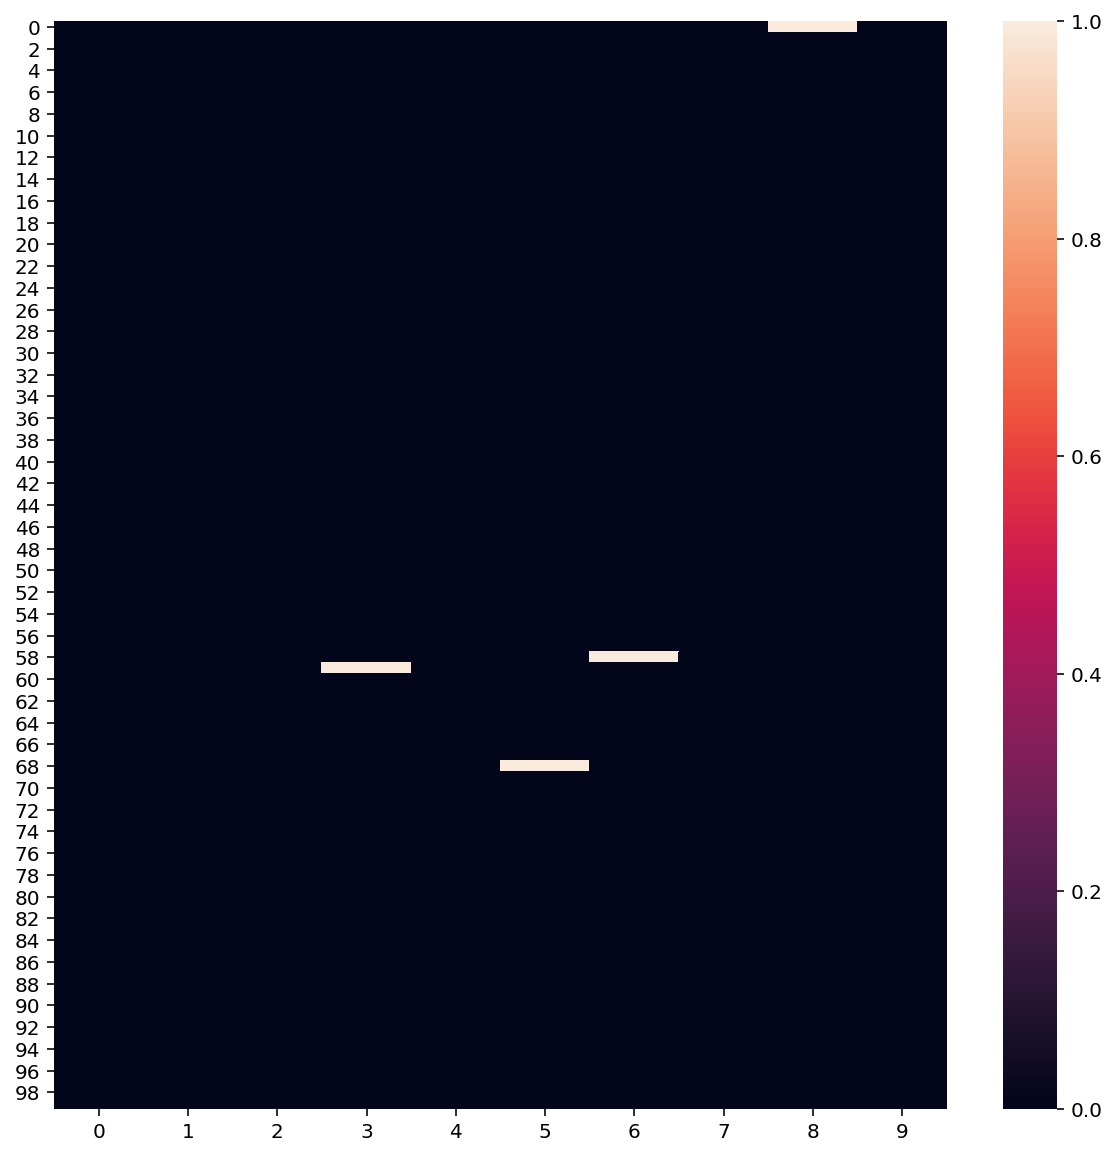

In [210]:
sns.heatmap(mask_history[130][2] - mask_history[-1][2])

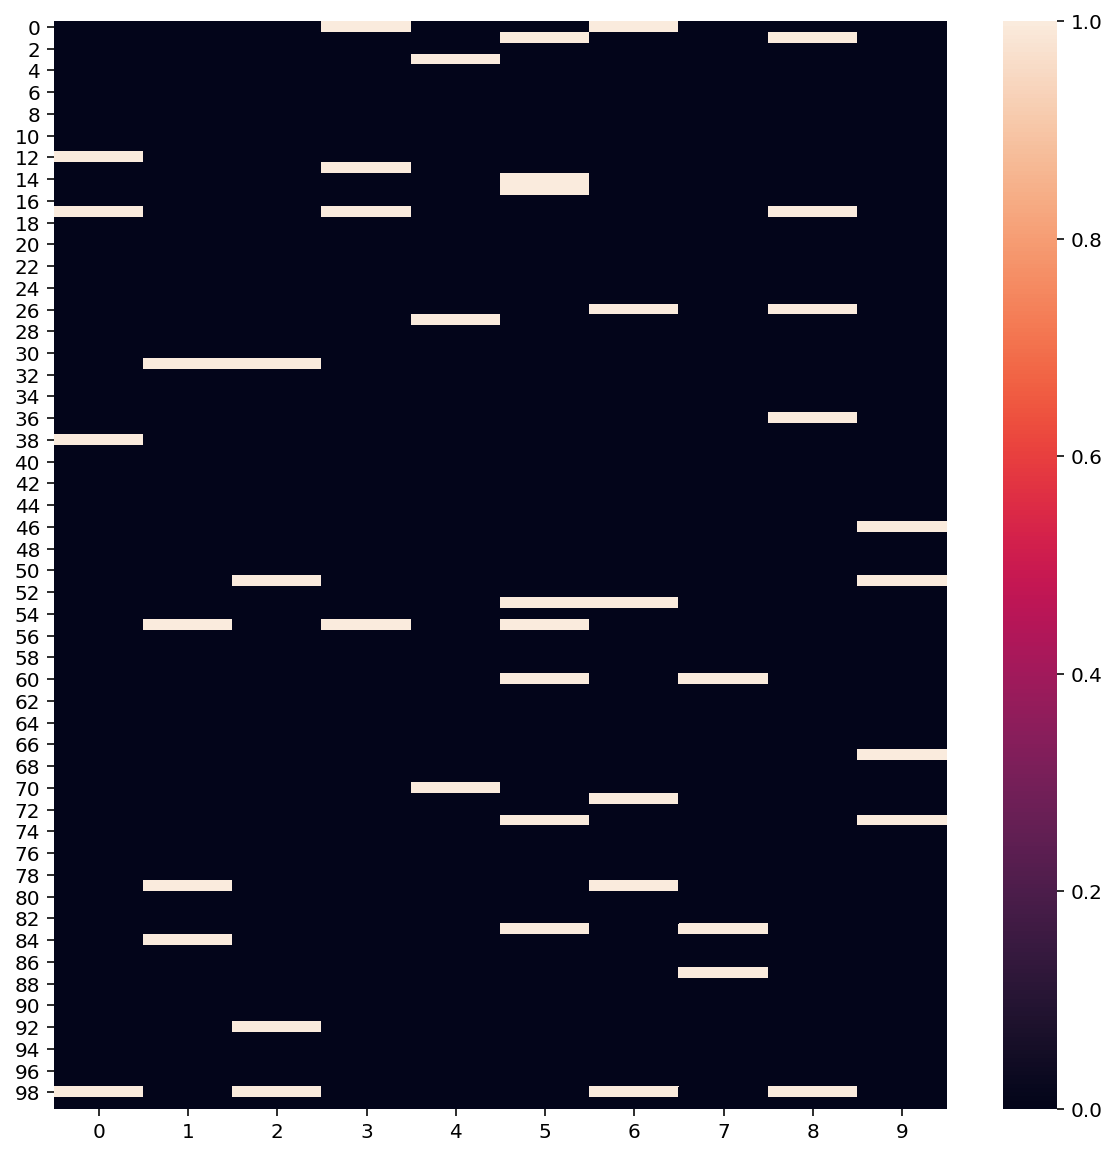

In [205]:
sns.heatmap(mask_history[-1][2])

<BarContainer object of 199 artists>

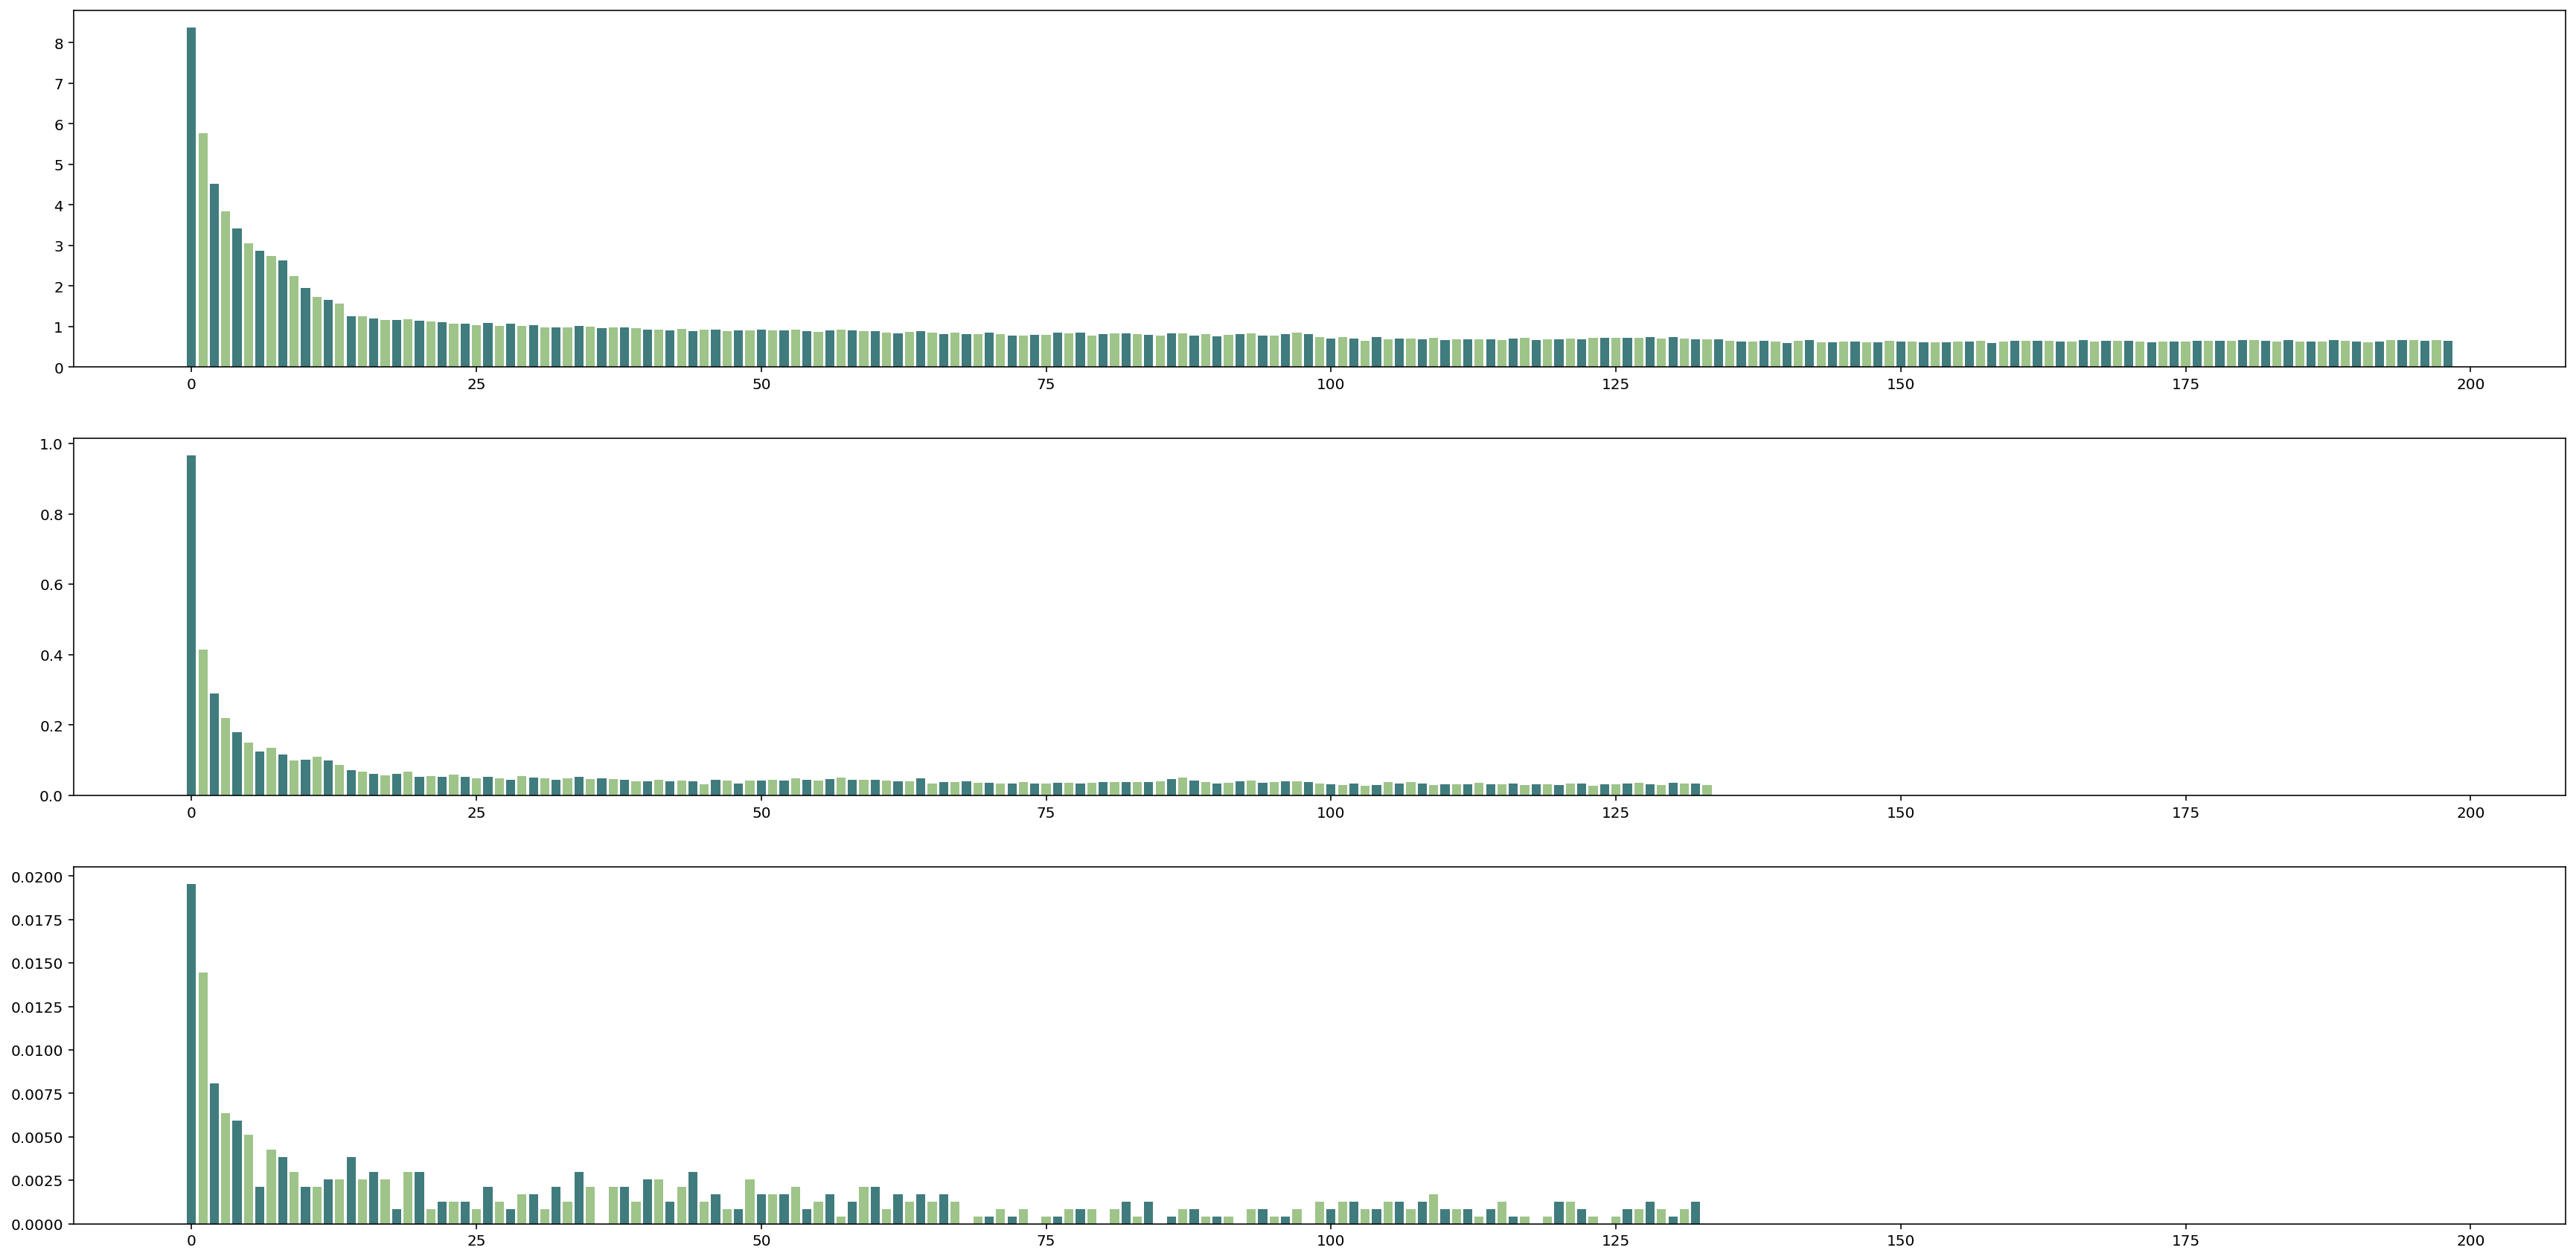

In [197]:
plt.figure(figsize=(30,15))
N = 199
ind = np.arange(N)
plt.subplot(3,1,1)
plt.bar(ind, no_changes[:,0], color=[u'#407C7D', u'#9EC489'])
plt.subplot(3,1,2)
plt.bar(ind, no_changes[:,1], color=[u'#407C7D', u'#9EC489'])
plt.subplot(3,1,3)
plt.bar(ind, no_changes[:,2], color=[u'#407C7D', u'#9EC489'])

#plt.xticks(ind) # add loads of ticks
#plt.grid()

#plt.gca().margins(x=0)
#plt.gcf().canvas.draw()
#tl = plt.gca().get_xticklabels()
#maxsize = max([t.get_window_extent().width for t in tl])
#m = 0.2 # inch margin
#s = maxsize/plt.gcf().dpi*N+2*m
#margin = m/plt.gcf().get_size_inches()[0]

#plt.gcf().subplots_adjust(left=margin, right=1.-margin)
#plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

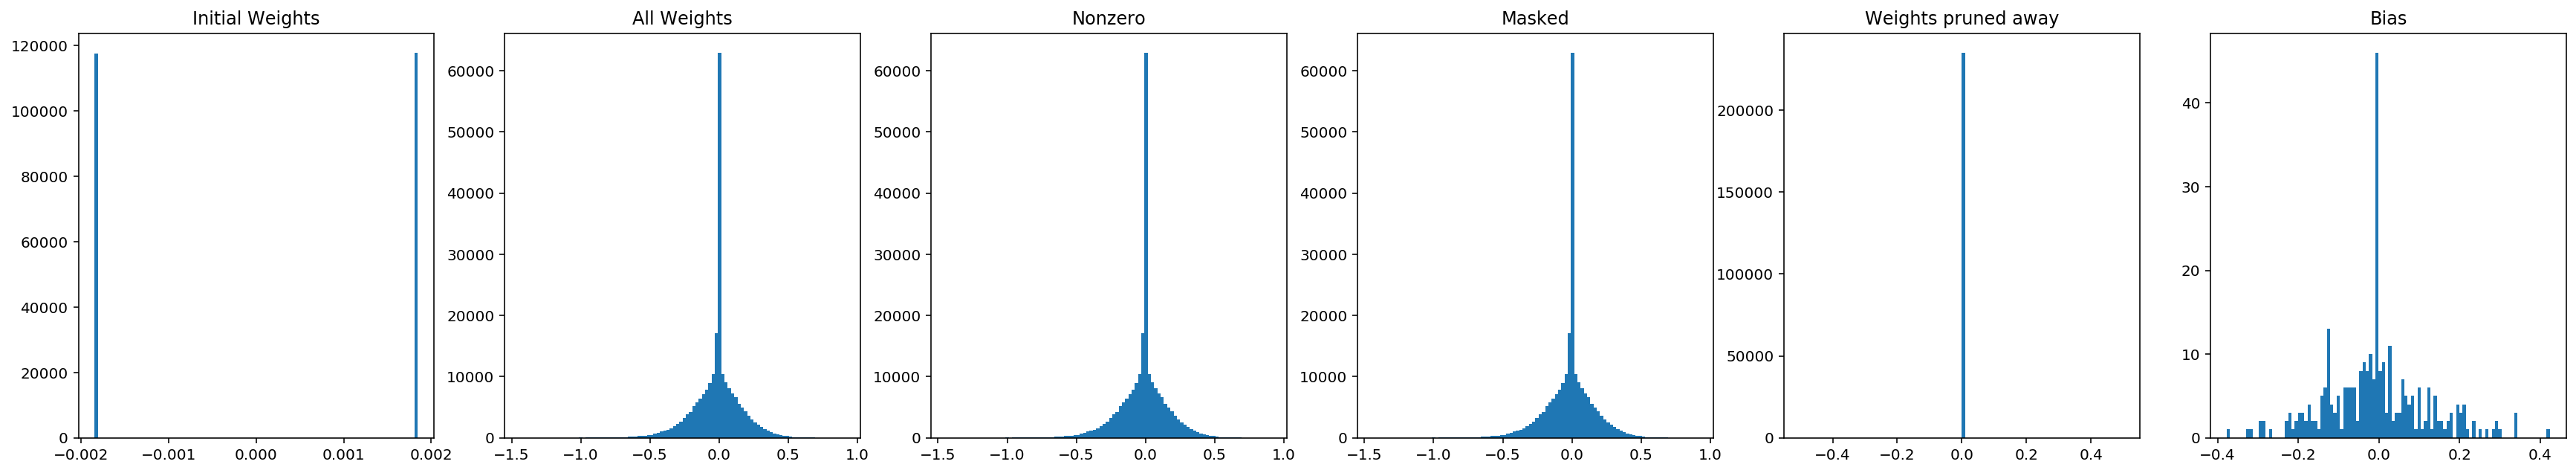

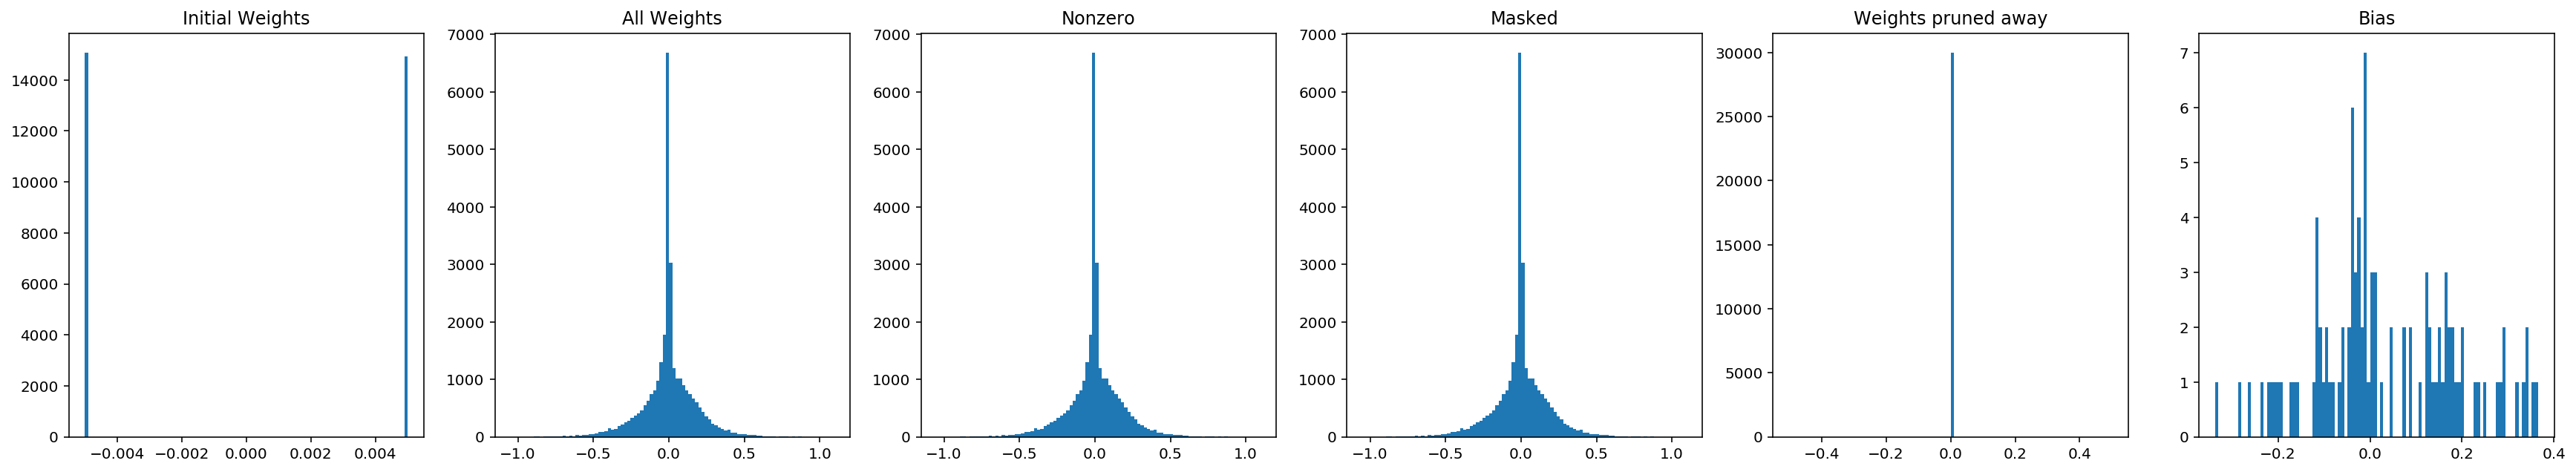

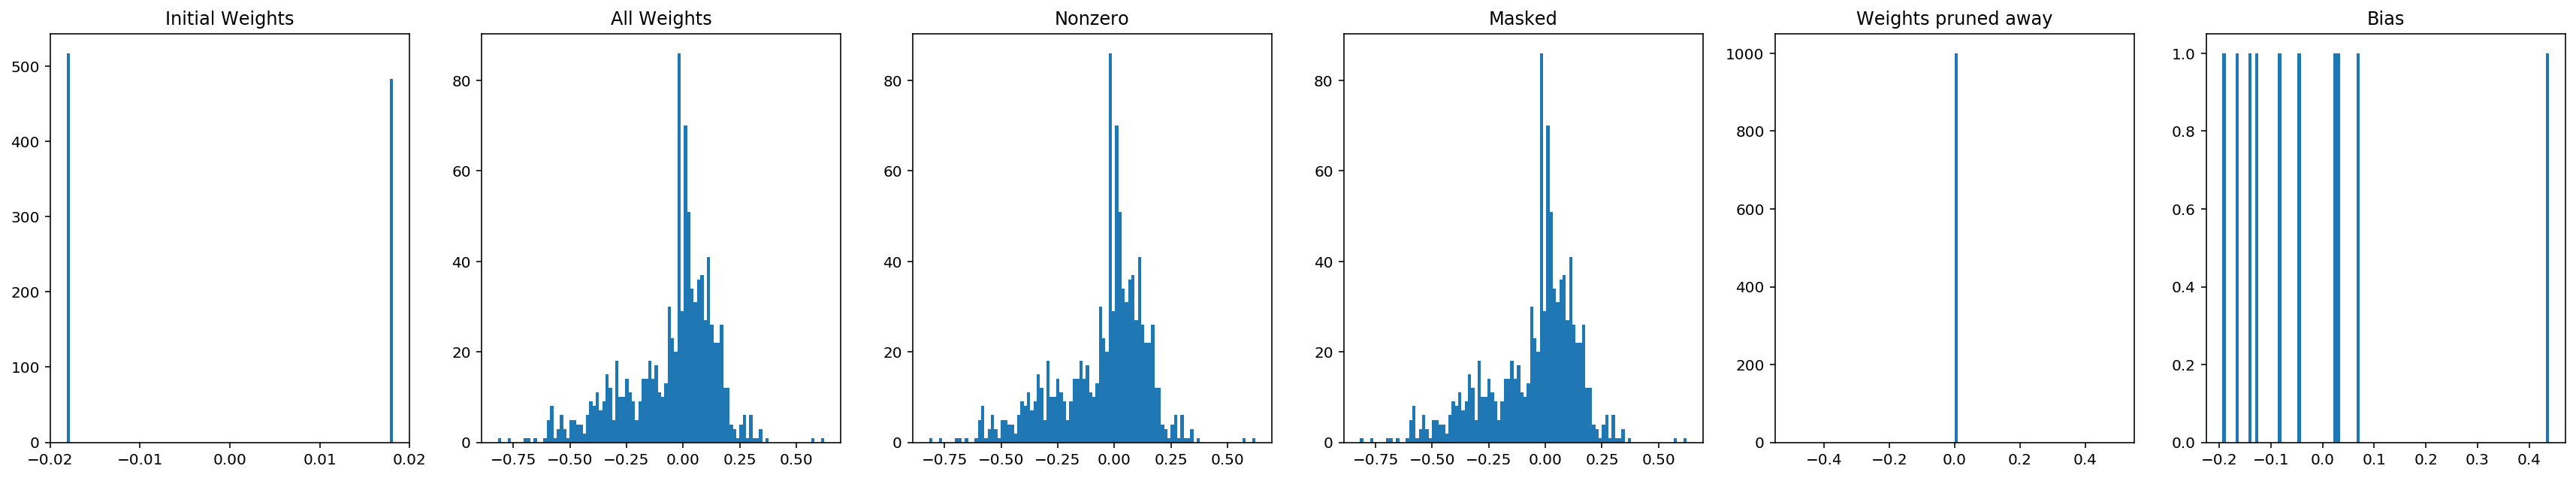

In [129]:
for i, layer in enumerate(fcn.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,6,1)
    plt.title("Initial Weights")
    _ = plt.hist(initial_weights[i][0].flatten(), bins=100)
    plt.subplot(1,6,2)
    plt.title("All Weights")
    _ = plt.hist(layer.get_weights()[0].flatten(), bins=100)
    plt.subplot(1,6,3)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,4)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,5)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)
    plt.subplot(1,6,6)
    plt.title("Bias")
    _ = plt.hist(layer.get_bias().numpy().flatten(), bins=100)

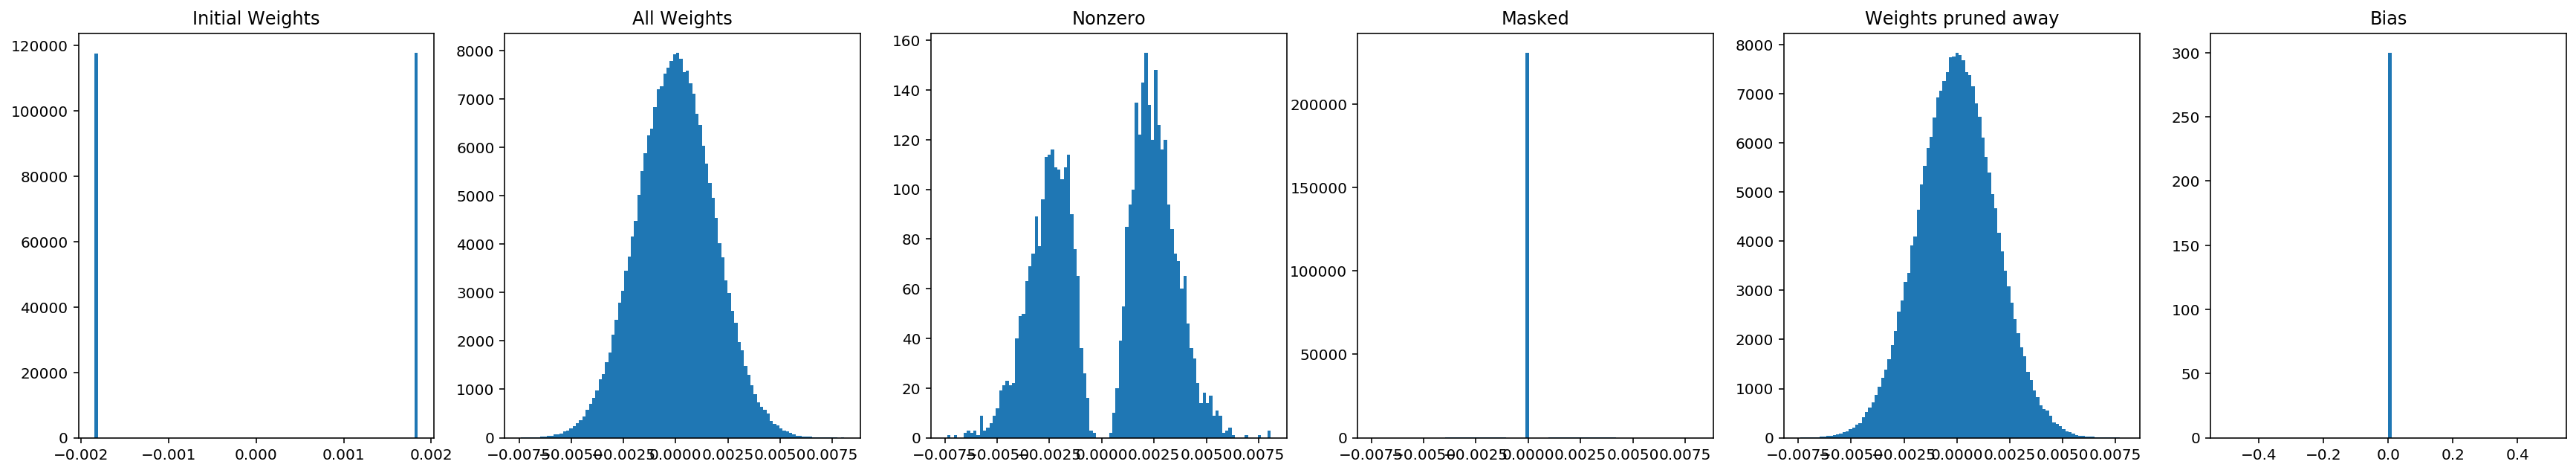

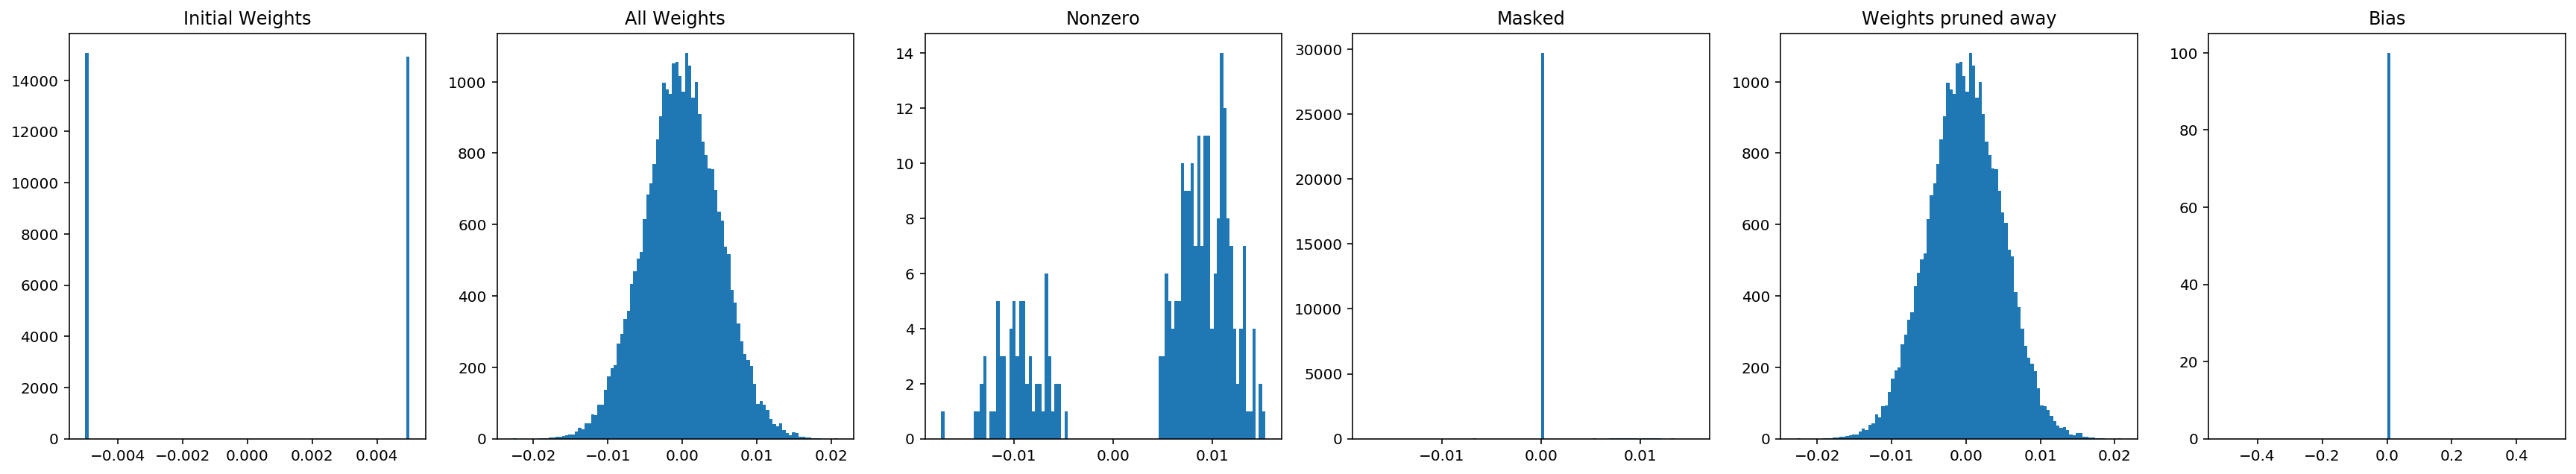

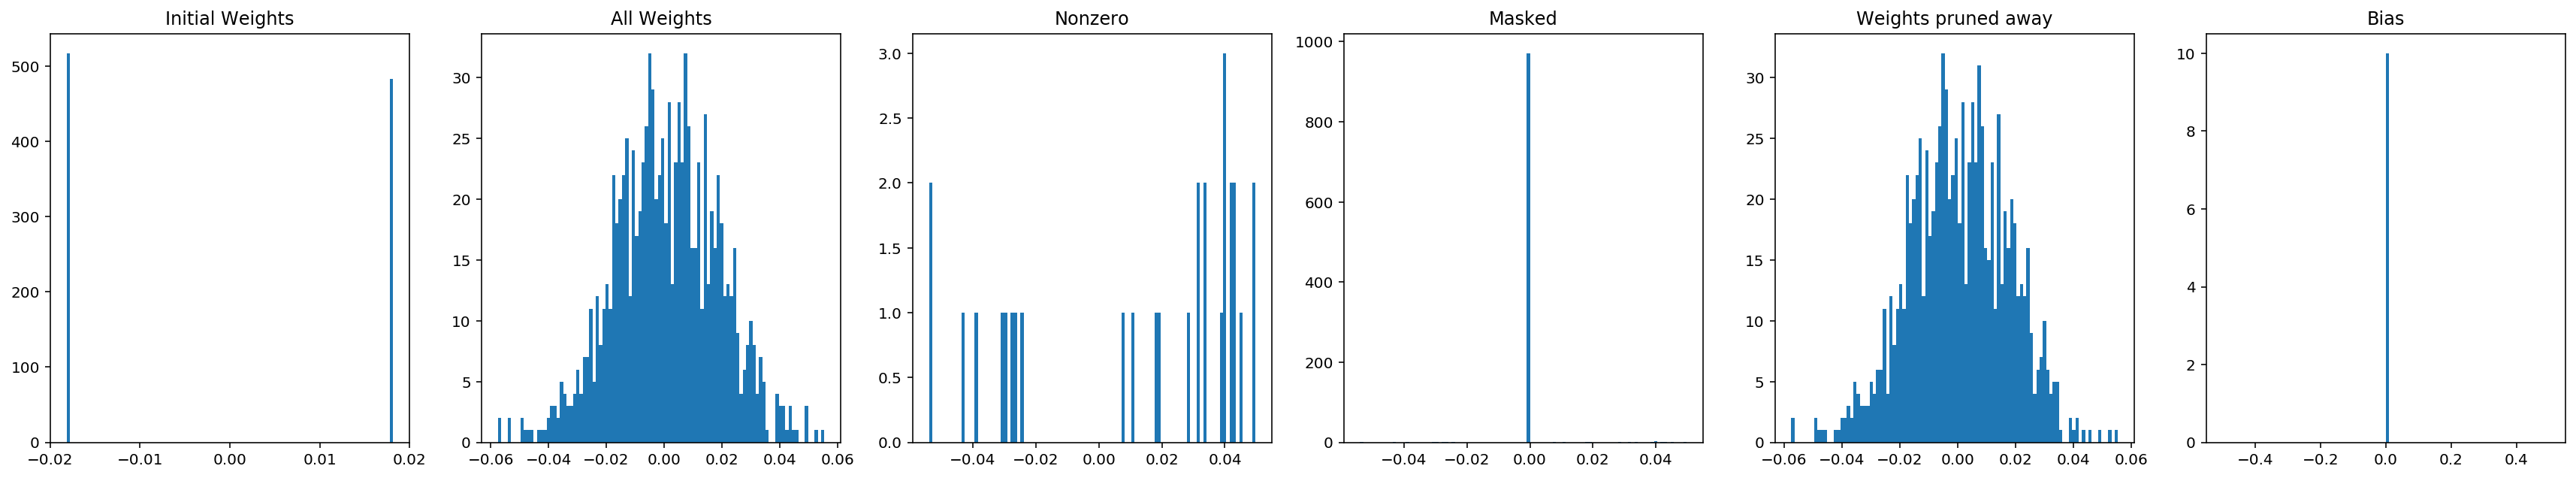

In [130]:
for i, layer in enumerate(fcn_mask.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,6,1)
    plt.title("Initial Weights")
    _ = plt.hist(initial_weights[i][0].flatten(), bins=100)
    plt.subplot(1,6,2)
    plt.title("All Weights")
    _ = plt.hist(layer.get_normal_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,3)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,4)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,5)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)
    plt.subplot(1,6,6)
    plt.title("Bias")
    _ = plt.hist(layer.get_bias().numpy().flatten(), bins=100)